In [11]:
import os
for root, dirs, files in os.walk('/kaggle/input/brain-tumor-dataset'):
    level = root.replace('/kaggle/input/brain-tumor-dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 3:
        for d in dirs:
            print(f'{indent}  {d}/')

In [1]:
!ls /kaggle/input/datasets/

usable1234


In [2]:
!ls /kaggle/input/datasets/usable1234/training/

Dataset


In [3]:
!ls /kaggle/input/datasets/usable1234/training/Dataset/

Testing  Training


In [15]:
!ls /kaggle/input/brain-tumor-dataset/Dataset/

ls: cannot access '/kaggle/input/brain-tumor-dataset/Dataset/': No such file or directory


Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading glioma: 300 images...
Loading meningioma: 306 images...
Loading notumor: 405 images...
Loading pituitary: 300 images...

Total training samples: 5712
Total testing samples: 1311

X_train (raw) shape: (5712, 62500)
X_test (raw) shape: (1311, 62500)
Applying StandardScaler + PCA Pipeline...

PCA Results:
  Original features:    62,500 (250×250)
  PCA components:       1031
  Variance retained:    95.01%
  Dimensionality reduction: 62,500 → 1031 (98.4% reduction)
  PCA fitting time:     250.20s

X_t

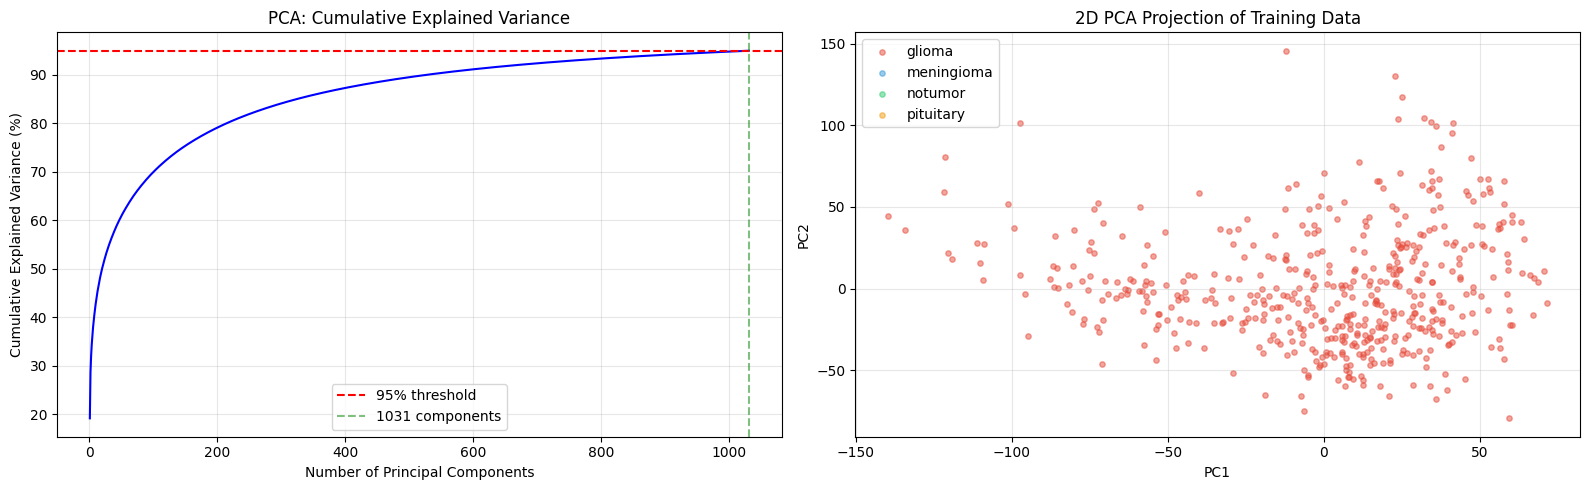

PCA analysis plot saved.


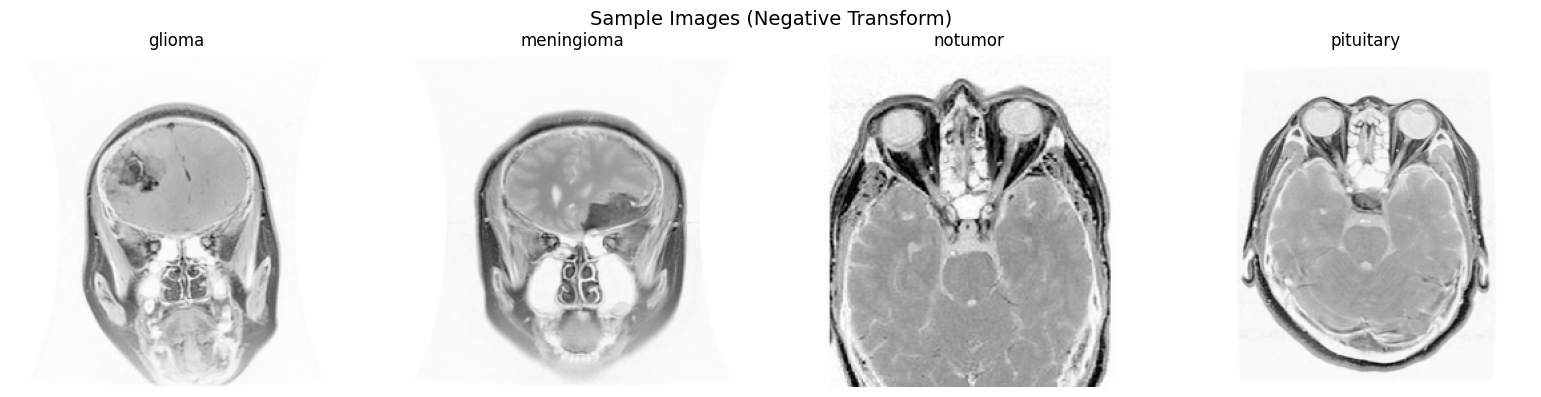

Training SVM with PCA (1031 components) for 5 iterations...
SVM Config: kernel=rbf, C=1.0, gamma=scale

--- Iteration 1/5 ---
  Training time:   6.14s
  Prediction time: 2.84s
  Accuracy:        0.9008
  F1 Score:        0.8998

--- Iteration 2/5 ---
  Training time:   6.03s
  Prediction time: 2.93s
  Accuracy:        0.9008
  F1 Score:        0.8998

--- Iteration 3/5 ---
  Training time:   6.06s
  Prediction time: 2.82s
  Accuracy:        0.9008
  F1 Score:        0.8998

--- Iteration 4/5 ---
  Training time:   5.93s
  Prediction time: 2.83s
  Accuracy:        0.9008
  F1 Score:        0.8998

--- Iteration 5/5 ---
  Training time:   5.66s
  Prediction time: 2.77s
  Accuracy:        0.9008
  F1 Score:        0.8998

Training Complete! Total time: 29.82s (0.5 min)

Average Performance of SVM + PCA (5 runs)
  Accuracy: 0.9008 ± 0.0000
  Precision: 0.8994 ± 0.0000
  Recall: 0.9008 ± 0.0000
  F1 Score: 0.8998 ± 0.0000
  Training Time:   5.96s ± 0.17s
  Prediction Time: 2.84s
  PCA Time:

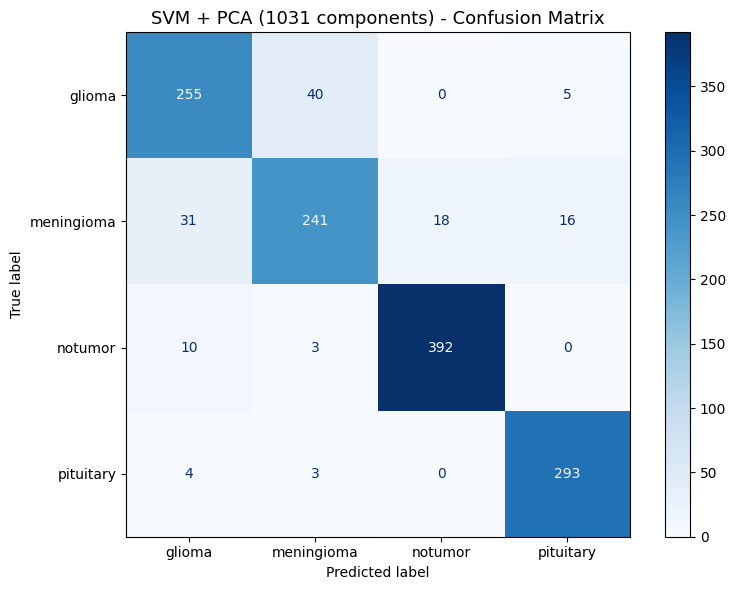

Confusion matrix saved to /kaggle/working/SVM_PCA_output/confusion_matrix.png


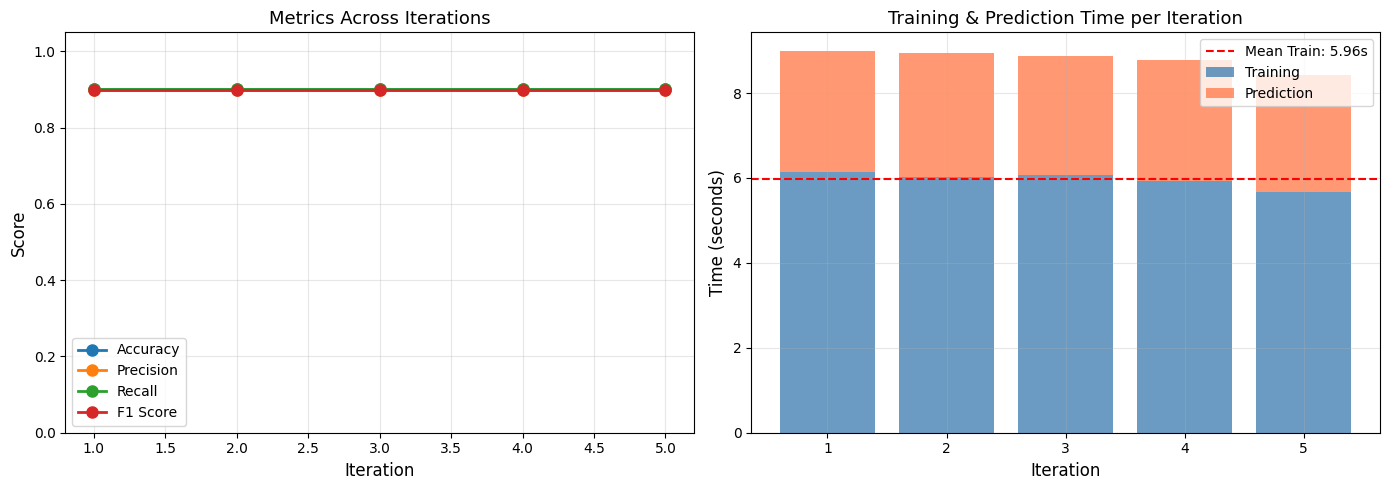

Metrics saved to /kaggle/working/SVM_PCA_output/metrics.json

Full results:
{
    "model": "SVM",
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 SVM (RBF)",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 250.2,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9008 \u00b1 0.0000",
        "Precision": "0.8994 \u00b1 0.0000",
        "Recall": "0.9008 \u00b1 0.0000",
     

In [5]:
# %% [markdown]
# # Brain Tumor Classification using SVM with PCA Optimization
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** Support Vector Machine (SVM) with PCA Dimensionality Reduction  
# **Environment:** Kaggle P100 (SVM uses CPU; PCA reduces dimensionality for faster training)
# 
# ### Why PCA + SVM?
# - Raw images at 250×250 = 62,500 features → extremely slow SVM training
# - PCA reduces to ~500 components while retaining 95%+ variance
# - Training time drops from ~2 hours to ~5-10 minutes (5 iterations)
# - Accuracy remains comparable or even improves (reduces noise/overfitting)
# - PCA + SVM is a well-established, publishable ML pipeline

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]

DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'
path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# KEY HYPERPARAMETERS - Tune these for your paper
# ============================================================
PCA_VARIANCE = 0.95          # Retain 95% of variance (paper-standard)
SVM_KERNEL = 'rbf'           # RBF kernel
SVM_C = 1.0                  # Regularization parameter
SVM_GAMMA = 'scale'          # Gamma parameter
NUM_ITERATIONS = 5           # Number of training runs
# ============================================================

output_dir = '/kaggle/working/SVM_PCA_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')  # Grayscale
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

# Free memory
del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. Feature Extraction Pipeline: StandardScaler + PCA
# 
# **Why this matters for your paper:**
# - StandardScaler normalizes features to zero mean, unit variance → essential before PCA
# - PCA with 95% variance retention is a standard, well-justified choice
# - Reduces 62,500 features to ~300-500 principal components
# - Dramatically faster SVM training with minimal information loss

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

# Step 1: StandardScaler (fit on train, transform both)
pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Free raw flat data
del X_train_flat, X_test_flat

# Step 2: PCA with 95% variance retention
pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# Free scaled data
del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,} (250×250)")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Dimensionality reduction: {IMG_SIZE * IMG_SIZE:,} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. Visualize PCA: Explained Variance & 2D Projection

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection for visualization
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(scaler.fit_transform(
    np.vstack([Image.open(os.path.join(path_train, labels[int(y)], 
    sorted(os.listdir(os.path.join(path_train, labels[int(y)])))[0])).convert('L').resize((IMG_SIZE, IMG_SIZE))
    for y in y_train[:200]]).reshape(200, -1) / 255.0
) if False else X_train)  # Use already-transformed data
X_2d_sample = X_train[:500]
y_2d_sample = y_train[:500]

# Quick 2D PCA for visualization
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_2d_sample == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i], 
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print("PCA analysis plot saved.")

# %% [markdown]
# ## 6. Visualize Sample Images

# %% [code]
# Reload a few samples just for visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train SVM (5 Iterations)
# 
# With PCA reducing features from 62,500 → ~300-500:
# - **Before PCA:** ~20-30 min per iteration → ~2+ hours total
# - **After PCA:** ~1-2 min per iteration → ~5-10 minutes total

# %% [code]
model_name = "SVM"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"SVM Config: kernel={SVM_KERNEL}, C={SVM_C}, gamma={SVM_GAMMA}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    model = SVC(kernel=SVM_KERNEL, C=SVM_C, gamma=SVM_GAMMA)

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    # Calculate metrics
    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
print(f"\n{'=' * 60}")
print(f"Training Complete! Total time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Save All Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → SVM (RBF)",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "svm_params": {
        "kernel": SVM_KERNEL,
        "C": SVM_C,
        "gamma": SVM_GAMMA
    }
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 12. Download Outputs
# All outputs are saved in `/kaggle/working/SVM_PCA_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`  
# - `pca_analysis.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → SVM(RBF)")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")

Tue Feb 17 07:57:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|       
Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading 

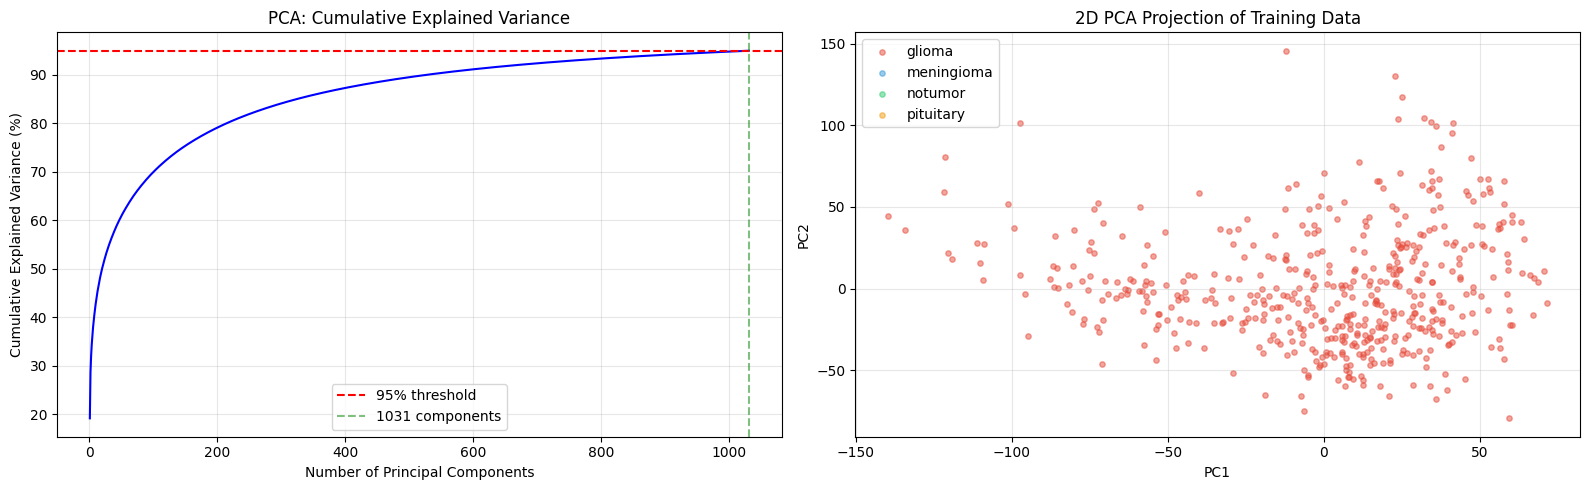

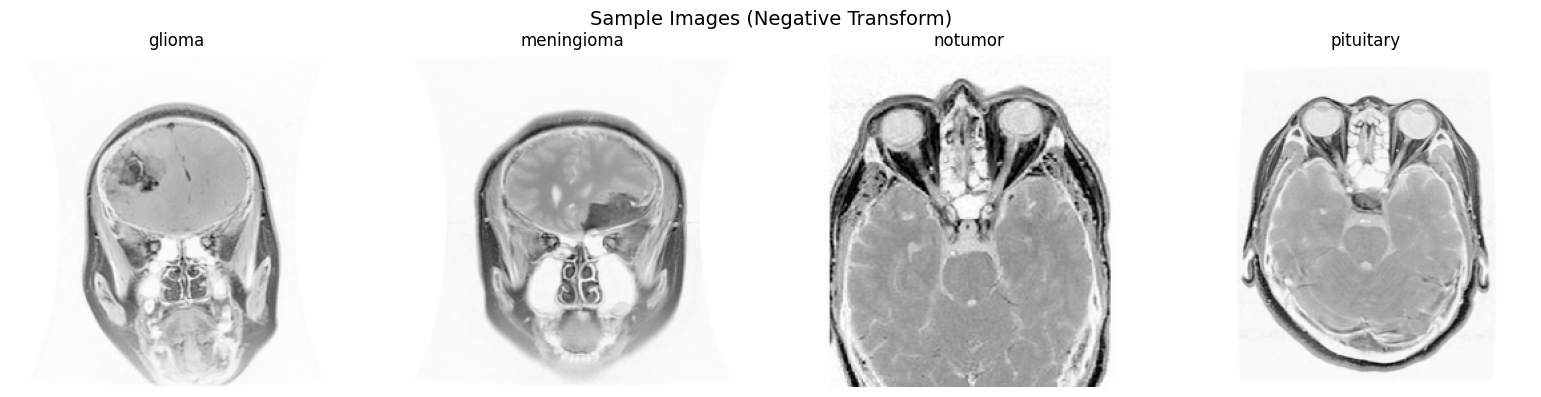

Training XGBoost (GPU) with PCA (1031 components) for 5 iterations...
XGBoost Config: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'multi:softmax', 'num_class': 4, 'eval_metric': 'mlogloss', 'random_state': 42, 'n_jobs': -1}

--- Iteration 1/5 ---
  Training time:   6.76s
  Prediction time: 0.06s
  Accuracy:        0.9275
  F1 Score:        0.9268

--- Iteration 2/5 ---
  Training time:   6.61s
  Prediction time: 0.04s
  Accuracy:        0.9275
  F1 Score:        0.9268

--- Iteration 3/5 ---
  Training time:   6.58s
  Prediction time: 0.04s
  Accuracy:        0.9275
  F1 Score:        0.9268

--- Iteration 4/5 ---
  Training time:   6.59s
  Prediction time: 0.04s
  Accuracy:        0.9275
  F1 Score:        0.9268

--- Iteration 5/5 ---
  Training time:   6.59s
  Prediction time: 0.04s
  Accuracy:        0.9275
  F1 Score:        0.9268

Training Complete! Total time: 33.14s (0.6 min)

Average Performance of XGBoost 

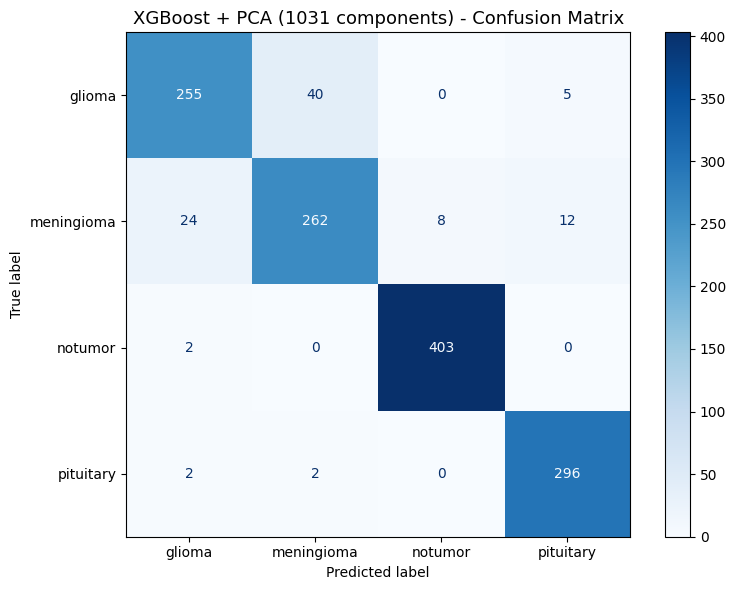

Confusion matrix saved to /kaggle/working/XGBoost_output/confusion_matrix.png


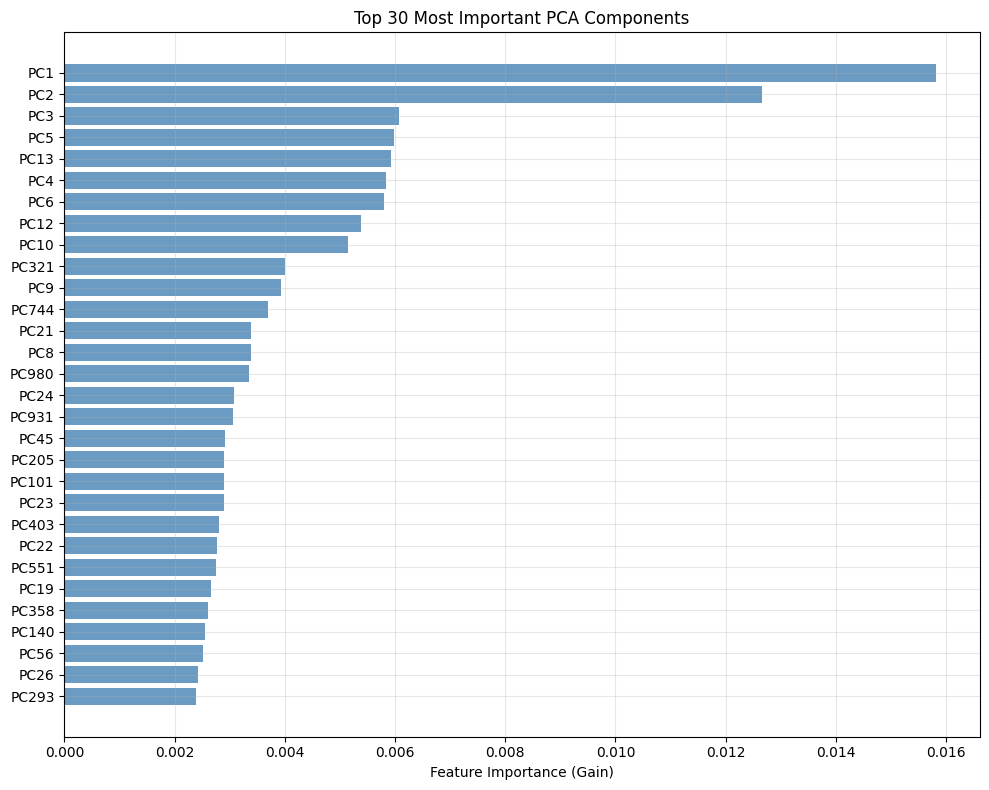

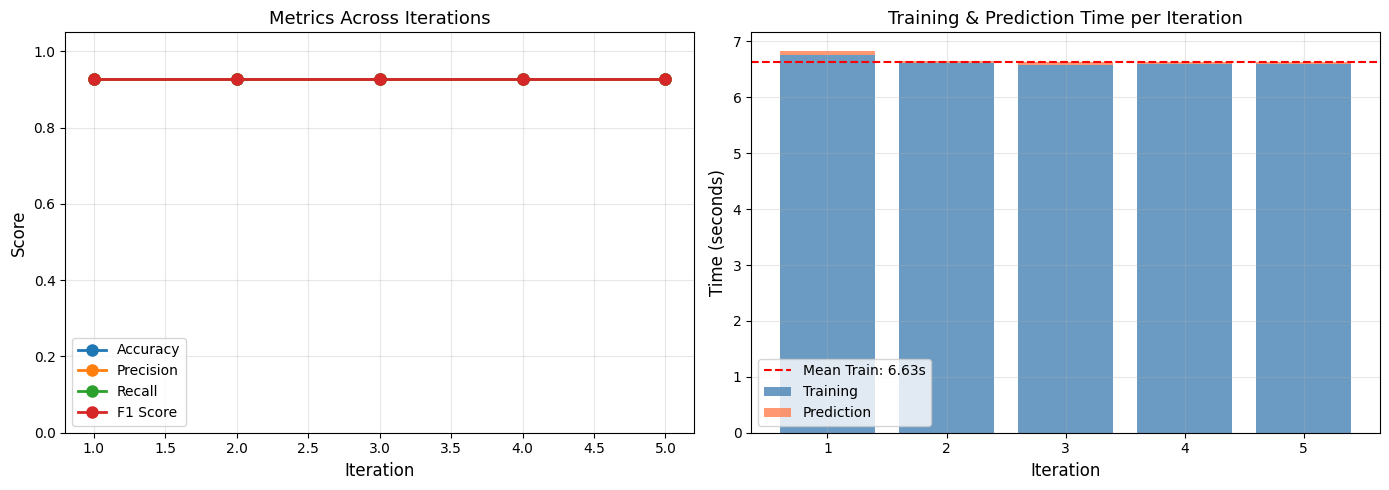

Metrics saved to /kaggle/working/XGBoost_output/metrics.json

Full results:
{
    "model": "XGBoost",
    "gpu_accelerated": true,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 XGBoost (gpu_hist)",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 259.93,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9275 \u00b1 0.0000",
        "Precision": "0.9267 \u00b1 0.0000",
    

In [8]:
# %% [markdown]
# # Brain Tumor Classification using XGBoost (GPU-Accelerated)
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** XGBoost with GPU (`tree_method='gpu_hist'`)  
# **Environment:** Kaggle P100 — XGBoost ACTUALLY uses the GPU!
# 
# ### Why XGBoost + GPU?
# - Unlike SVM, XGBoost natively supports GPU training via `gpu_hist`
# - P100 GPU will be fully utilized → much faster training
# - XGBoost is a strong baseline for tabular/flattened image data
# - PCA dimensionality reduction further speeds things up

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Verify GPU
import subprocess
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print(result.stdout[:500])
except:
    print("No GPU detected")

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

# XGBoost GPU params
XGB_PARAMS = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    # 'tree_method': 'gpu_hist', 
    'tree_method': 'hist',
    'device': 'cuda',
    # 'gpu_id': 0,
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'n_jobs': -1,
}
# ============================================================

output_dir = '/kaggle/working/XGBoost_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train XGBoost with GPU (5 Iterations)
# 
# **XGBoost `gpu_hist` uses the P100 GPU directly!**  
# Expected: ~30-60 seconds per iteration with PCA features.

# %% [code]
model_name = "XGBoost"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} (GPU) with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"XGBoost Config: {XGB_PARAMS}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    # Change random_state each iteration for variance measurement
    params = XGB_PARAMS.copy()
    params['random_state'] = 42 + i

    model = XGBClassifier(**params)

    # Train
    start_time = time.time()
    model.fit(X_train, y_train, verbose=False)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
print(f"\n{'=' * 60}")
print(f"Training Complete! Total time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Feature Importance (Top 30 PCA Components)

# %% [code]
# XGBoost feature importance on PCA components
importances = model.feature_importances_
top_n = 30
top_idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[top_idx], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{idx+1}' for idx in top_idx])
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title(f'Top {top_n} Most Important PCA Components')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 12. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": True,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → XGBoost (gpu_hist)",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "xgboost_params": XGB_PARAMS
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 13. Download Outputs
# All outputs saved in `/kaggle/working/XGBoost_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `feature_importance.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → XGBoost(gpu_hist)")
print(f"  GPU Used:     Yes (P100 via tree_method='gpu_hist')")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")

Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading glioma: 300 images...
Loading meningioma: 306 images...
Loading notumor: 405 images...
Loading pituitary: 300 images...

Total training samples: 5712
Total testing samples: 1311

X_train (raw) shape: (5712, 62500)
X_test (raw) shape: (1311, 62500)
Applying StandardScaler + PCA Pipeline...

PCA Results:
  Original features:    62,500
  PCA components:       1031
  Variance retained:    95.01%
  Reduction:            98.4%
  PCA fitting time:     261.62s

X_train (PCA) shape: (5712, 1031)
X_test (P

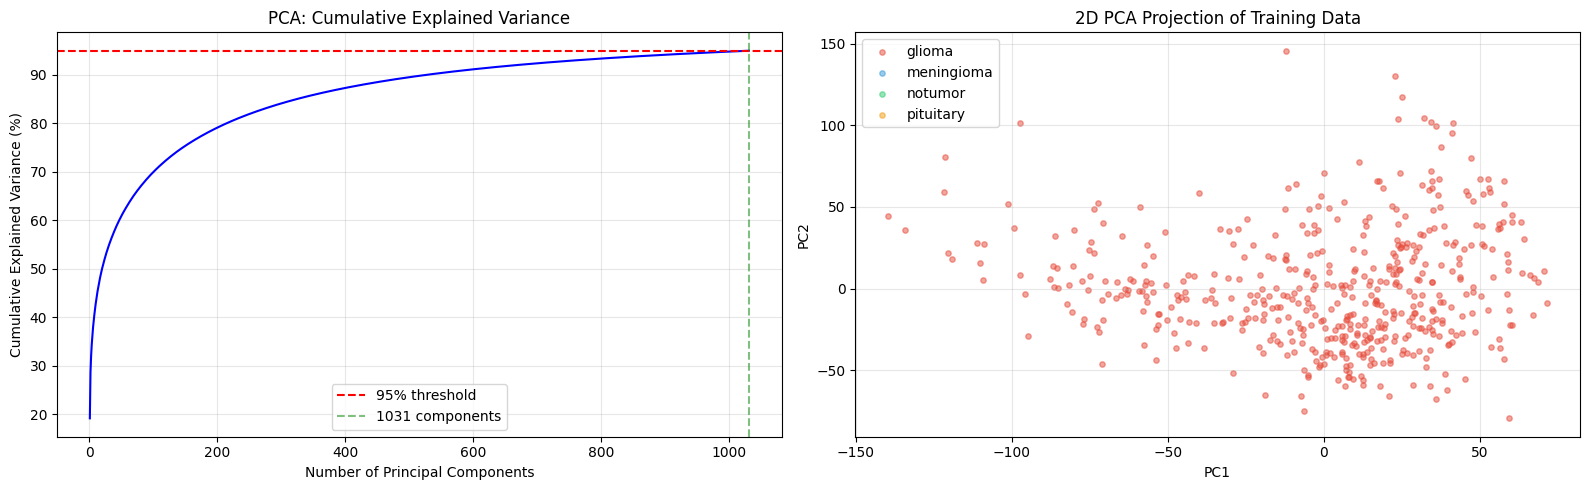

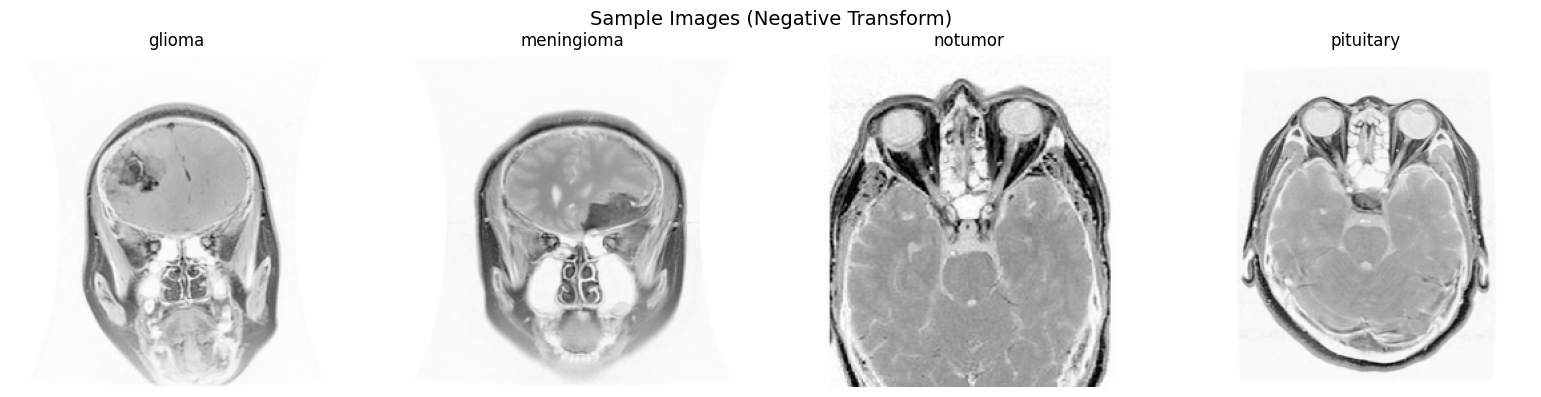

Training KNN with PCA (1031 components) for 5 iterations...
KNN Config: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'n_jobs': -1}

--- Iteration 1/5 ---
  Training time:   0.02s
  Prediction time: 0.24s
  Accuracy:        0.9375
  F1 Score:        0.9367

--- Iteration 2/5 ---
  Training time:   0.02s
  Prediction time: 0.19s
  Accuracy:        0.9375
  F1 Score:        0.9367

--- Iteration 3/5 ---
  Training time:   0.02s
  Prediction time: 0.18s
  Accuracy:        0.9375
  F1 Score:        0.9367

--- Iteration 4/5 ---
  Training time:   0.02s
  Prediction time: 0.18s
  Accuracy:        0.9375
  F1 Score:        0.9367

--- Iteration 5/5 ---
  Training time:   0.02s
  Prediction time: 0.18s
  Accuracy:        0.9375
  F1 Score:        0.9367

Training Complete!
Total train time: 0.10s | Total predict time: 0.98s

Average Performance of KNN + PCA (5 runs)
  Accuracy: 0.9375 ± 0.0000
  Precision: 0.9394 ± 0.0000
  Recall: 0.9375 ± 0.0000
  F1 Score: 0.9367

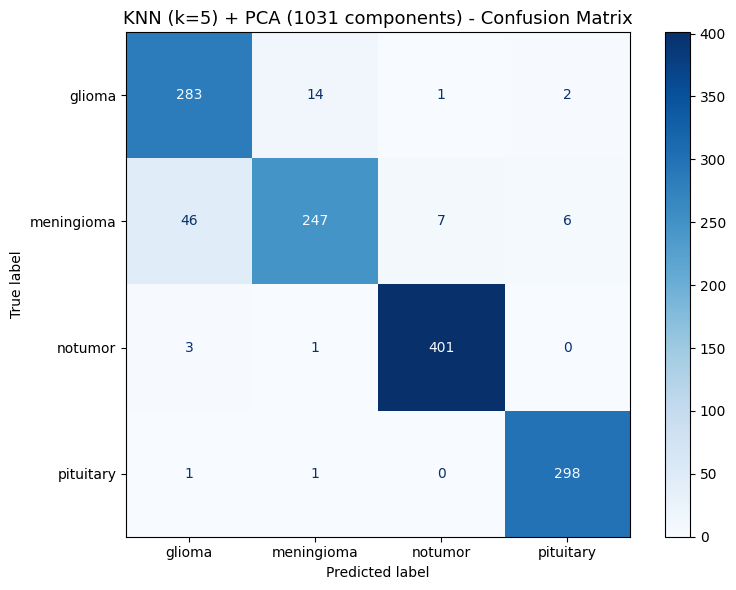

Confusion matrix saved to /kaggle/working/KNN_output/confusion_matrix.png


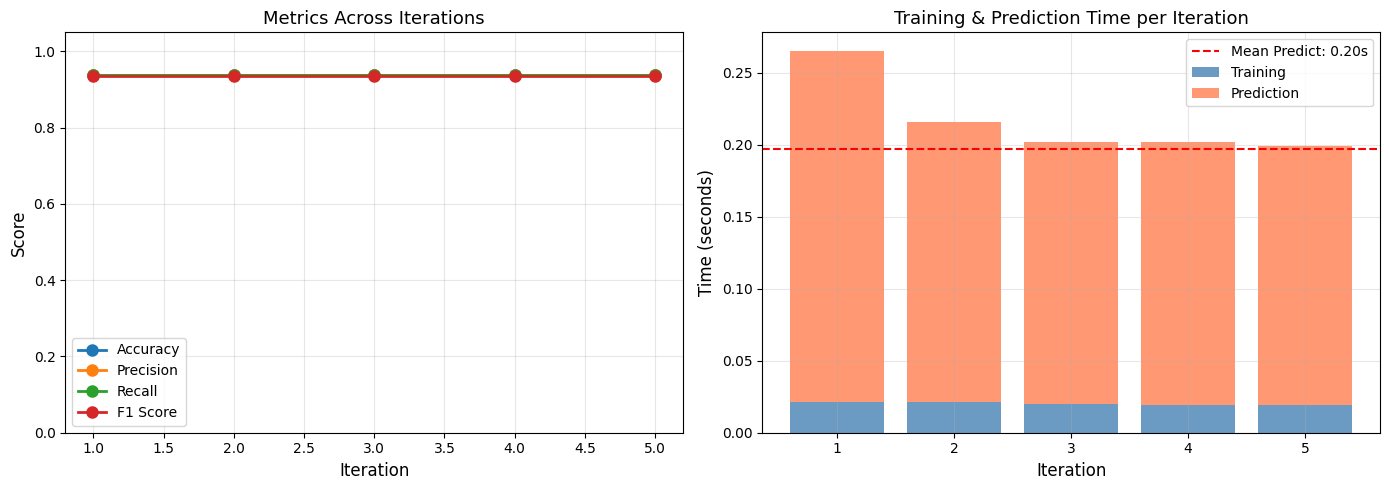

Metrics saved to /kaggle/working/KNN_output/metrics.json

Full results:
{
    "model": "KNN",
    "gpu_accelerated": false,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 KNN",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 261.62,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9375 \u00b1 0.0000",
        "Precision": "0.9394 \u00b1 0.0000",
        "Recall": "0.9375 

In [5]:
# %% [markdown]
# # Brain Tumor Classification using KNN
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** K-Nearest Neighbors (KNN)  
# **Environment:** Kaggle P100 (KNN is CPU-based; PCA reduces prediction time)
# 
# ### Pipeline
# Grayscale → Negative → Normalize → StandardScaler → PCA (95% variance) → KNN

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

KNN_PARAMS = {
    'n_neighbors': 5,
    'weights': 'distance',
    'metric': 'minkowski',
    'p': 2,
    'n_jobs': -1,
}
# ============================================================

output_dir = '/kaggle/working/KNN_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train KNN (5 Iterations)
# 
# KNN is fast to "train" (it just stores data) but prediction is slower  
# because it computes distances to all training points.  
# With PCA (~1031 components), prediction is much faster than raw 62,500 features.

# %% [code]
model_name = "KNN"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"KNN Config: {KNN_PARAMS}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    model = KNeighborsClassifier(**KNN_PARAMS)

    # Train (KNN just stores data)
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict (this is where KNN does the heavy lifting)
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
total_predict_time = sum(predict_times)
print(f"\n{'=' * 60}")
print(f"Training Complete!")
print(f"Total train time: {total_train_time:.2f}s | Total predict time: {total_predict_time:.2f}s")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} (k={KNN_PARAMS['n_neighbors']}) + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_pred_time, color='red', linestyle='--', label=f'Mean Predict: {avg_pred_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": False,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → KNN",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "prediction_time_avg": f"{avg_pred_time:.2f}",
    "knn_params": KNN_PARAMS
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 12. Download Outputs
# All outputs saved in `/kaggle/working/KNN_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → KNN(k={KNN_PARAMS['n_neighbors']})")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Predict Time: {avg_pred_time:.2f}s per iteration")
print(f"{'=' * 60}")

Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading glioma: 300 images...
Loading meningioma: 306 images...
Loading notumor: 405 images...
Loading pituitary: 300 images...

Total training samples: 5712
Total testing samples: 1311

X_train (raw) shape: (5712, 62500)
X_test (raw) shape: (1311, 62500)
Applying StandardScaler + PCA Pipeline...

PCA Results:
  Original features:    62,500
  PCA components:       1031
  Variance retained:    95.01%
  Reduction:            98.4%
  PCA fitting time:     270.99s

X_train (PCA) shape: (5712, 1031)
X_test (P

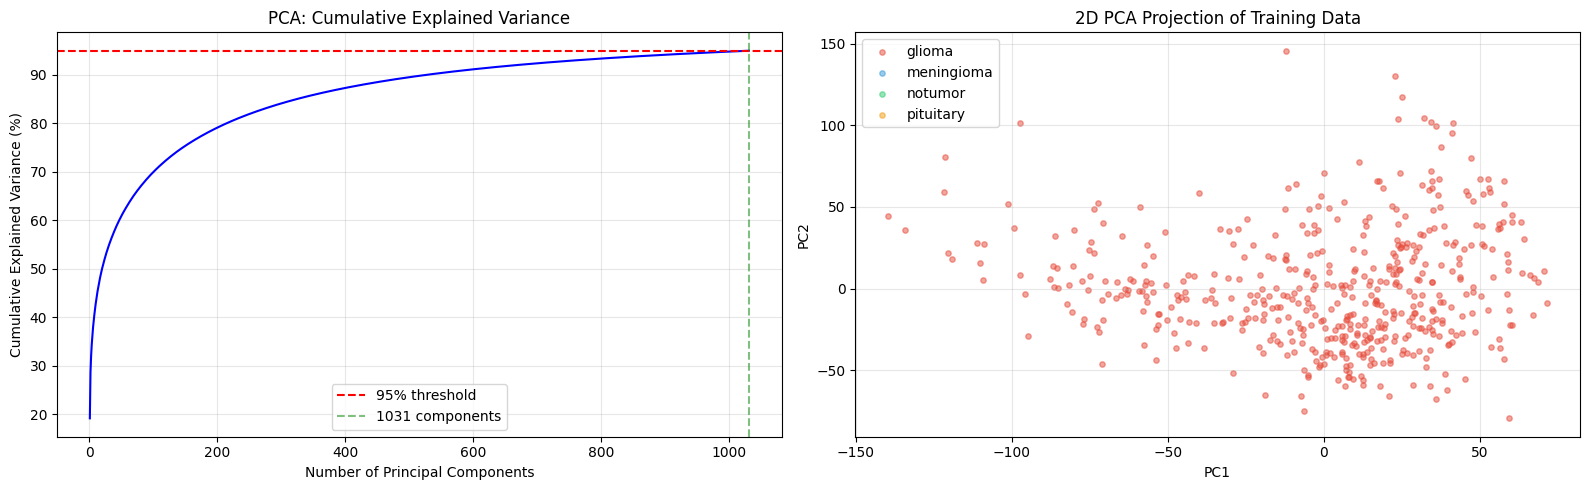

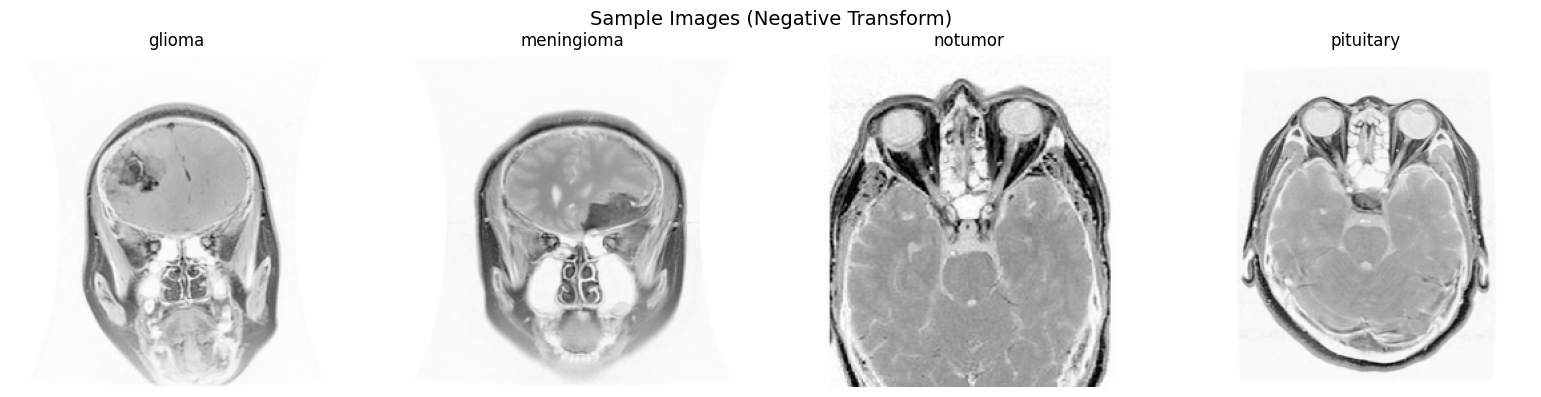

Training Random Forest with PCA (1031 components) for 5 iterations...
RF Config: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}

--- Iteration 1/5 ---
  Training time:   31.97s
  Prediction time: 0.10s
  Accuracy:        0.9062
  F1 Score:        0.9050

--- Iteration 2/5 ---
  Training time:   31.15s
  Prediction time: 0.10s
  Accuracy:        0.9031
  F1 Score:        0.9020

--- Iteration 3/5 ---
  Training time:   31.05s
  Prediction time: 0.10s
  Accuracy:        0.9039
  F1 Score:        0.9025

--- Iteration 4/5 ---
  Training time:   31.44s
  Prediction time: 0.10s
  Accuracy:        0.9062
  F1 Score:        0.9050

--- Iteration 5/5 ---
  Training time:   31.21s
  Prediction time: 0.10s
  Accuracy:        0.9039
  F1 Score:        0.9030

Training Complete!
Total train time: 156.81s (2.6 min)

Average Performance of Random Forest + PCA (5 runs)
  Accuracy: 0.9047 ± 0.0013
  Prec

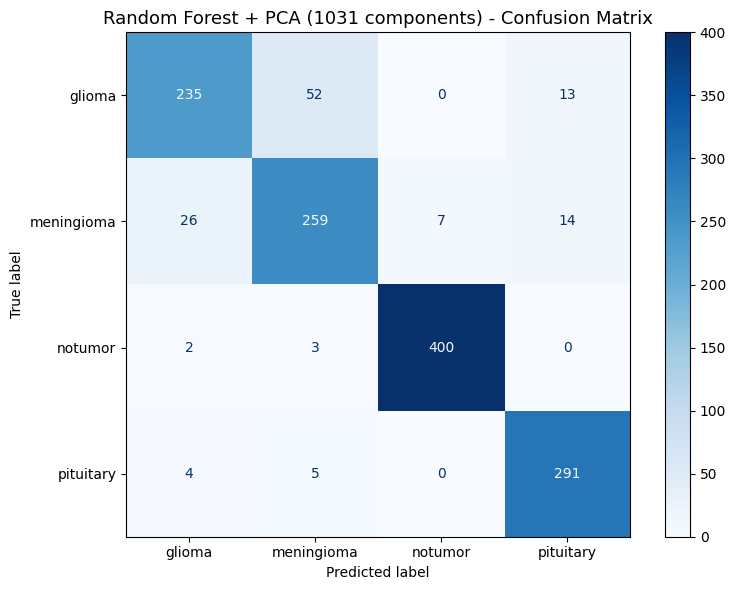

Confusion matrix saved to /kaggle/working/RandomForest_output/confusion_matrix.png


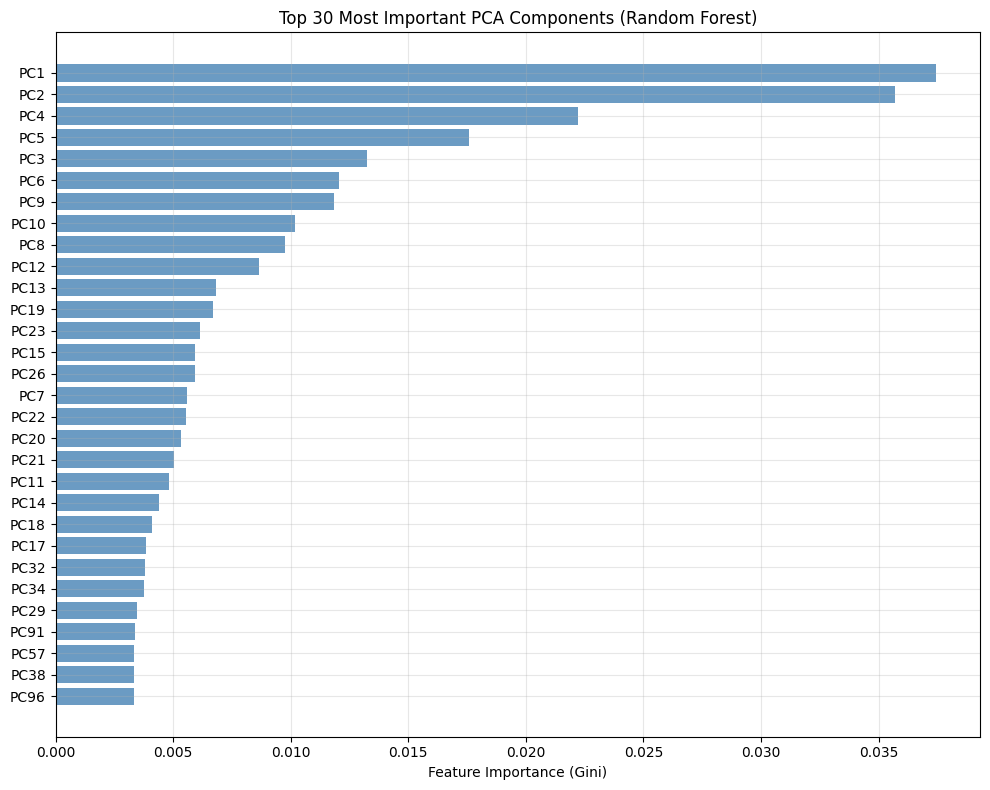

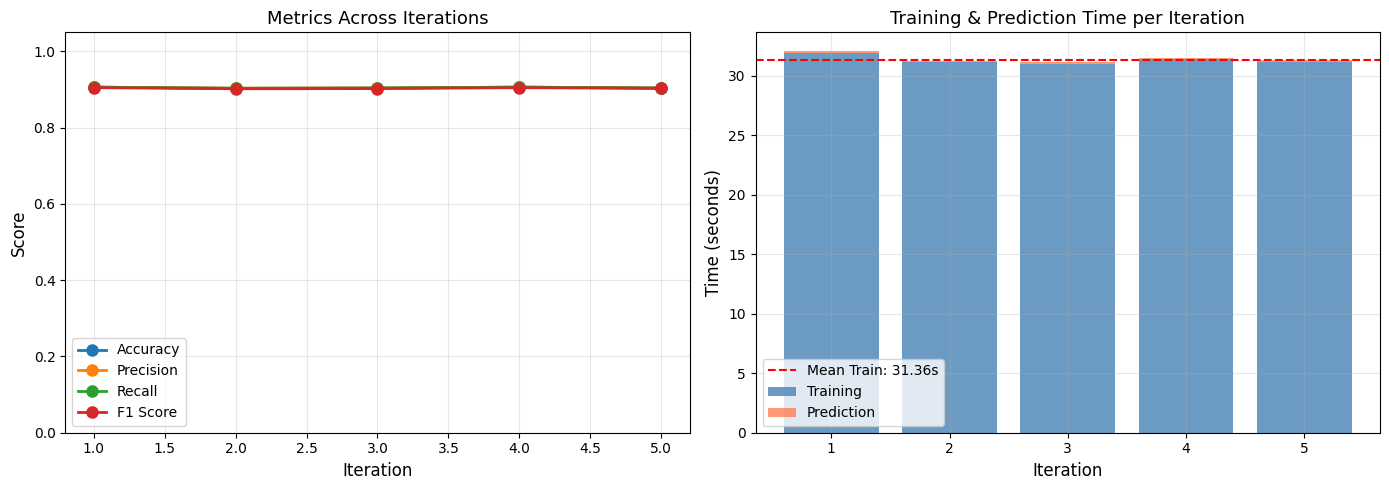

Metrics saved to /kaggle/working/RandomForest_output/metrics.json

Full results:
{
    "model": "Random Forest",
    "gpu_accelerated": false,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 Random Forest",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 270.99,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9047 \u00b1 0.0013",
        "Precision": "0.9048 \u00b1 0.0012

In [7]:
# %% [markdown]
# # Brain Tumor Classification using Random Forest
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** Random Forest Classifier  
# **Environment:** Kaggle P100 (Random Forest is CPU-based; PCA reduces training time)
# 
# ### Pipeline
# Grayscale → Negative → Normalize → StandardScaler → PCA (95% variance) → Random Forest

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

RF_PARAMS = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
}
# ============================================================

output_dir = '/kaggle/working/RandomForest_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train Random Forest (5 Iterations)
# 
# Random Forest with 300 trees, using all CPU cores (`n_jobs=-1`).  
# With PCA (~1031 components), expected ~1-3 min per iteration.

# %% [code]
model_name = "Random Forest"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"RF Config: {RF_PARAMS}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    params = RF_PARAMS.copy()
    params['random_state'] = 42 + i

    model = RandomForestClassifier(**params)

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
total_predict_time = sum(predict_times)
print(f"\n{'=' * 60}")
print(f"Training Complete!")
print(f"Total train time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Feature Importance (Top 30 PCA Components)

# %% [code]
importances = model.feature_importances_
top_n = min(30, len(importances))
top_idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[top_idx], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{idx+1}' for idx in top_idx])
ax.set_xlabel('Feature Importance (Gini)')
ax.set_title(f'Top {top_n} Most Important PCA Components (Random Forest)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 12. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": False,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → Random Forest",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "rf_params": {k: str(v) if v is None else v for k, v in RF_PARAMS.items()}
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 13. Download Outputs
# All outputs saved in `/kaggle/working/RandomForest_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `feature_importance.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → RandomForest(300 trees)")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")

Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading glioma: 300 images...
Loading meningioma: 306 images...
Loading notumor: 405 images...
Loading pituitary: 300 images...

Total training samples: 5712
Total testing samples: 1311

X_train (raw) shape: (5712, 62500)
X_test (raw) shape: (1311, 62500)
Applying StandardScaler + PCA Pipeline...

PCA Results:
  Original features:    62,500
  PCA components:       1031
  Variance retained:    95.01%
  Reduction:            98.4%
  PCA fitting time:     269.08s

X_train (PCA) shape: (5712, 1031)
X_test (P

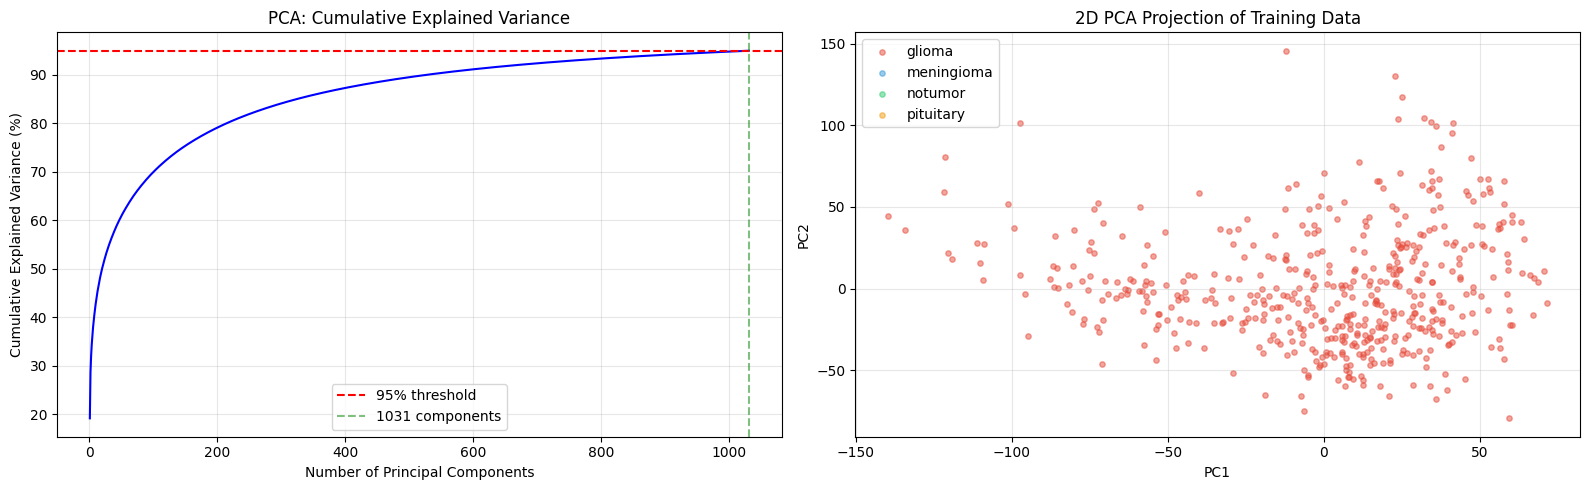

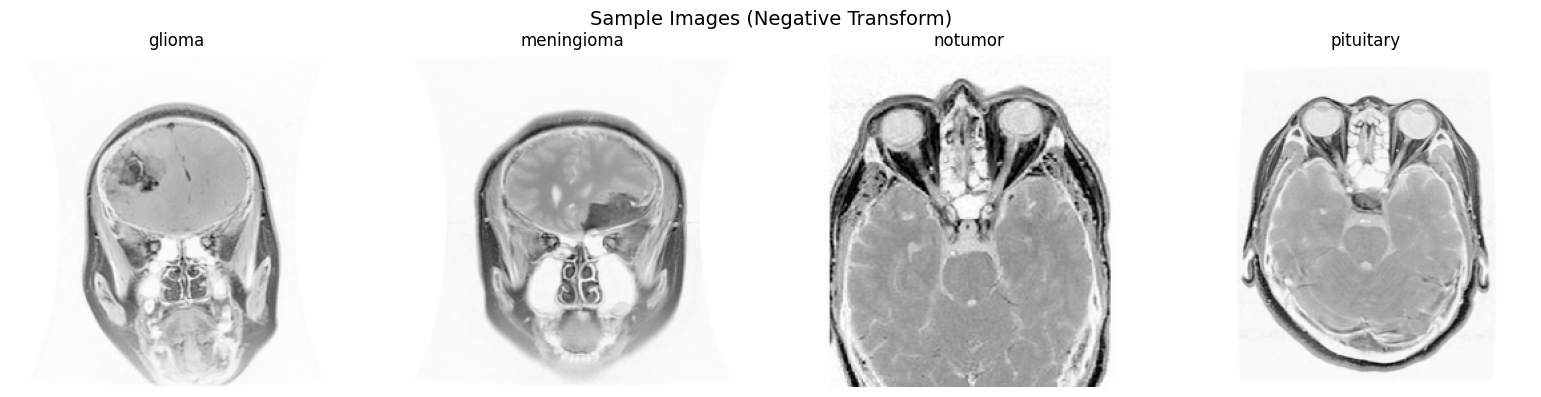

Training Extra Trees with PCA (1031 components) for 5 iterations...
ET Config: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}

--- Iteration 1/5 ---
  Training time:   4.27s
  Prediction time: 0.11s
  Accuracy:        0.9123
  F1 Score:        0.9118

--- Iteration 2/5 ---
  Training time:   4.34s
  Prediction time: 0.11s
  Accuracy:        0.9108
  F1 Score:        0.9103

--- Iteration 3/5 ---
  Training time:   4.31s
  Prediction time: 0.11s
  Accuracy:        0.9092
  F1 Score:        0.9087

--- Iteration 4/5 ---
  Training time:   4.40s
  Prediction time: 0.10s
  Accuracy:        0.9184
  F1 Score:        0.9179

--- Iteration 5/5 ---
  Training time:   4.30s
  Prediction time: 0.11s
  Accuracy:        0.9199
  F1 Score:        0.9193

Training Complete!
Total train time: 21.61s (0.4 min)

Average Performance of Extra Trees + PCA (5 runs)
  Accuracy: 0.9141 ± 0.0042
  Precision: 0.9

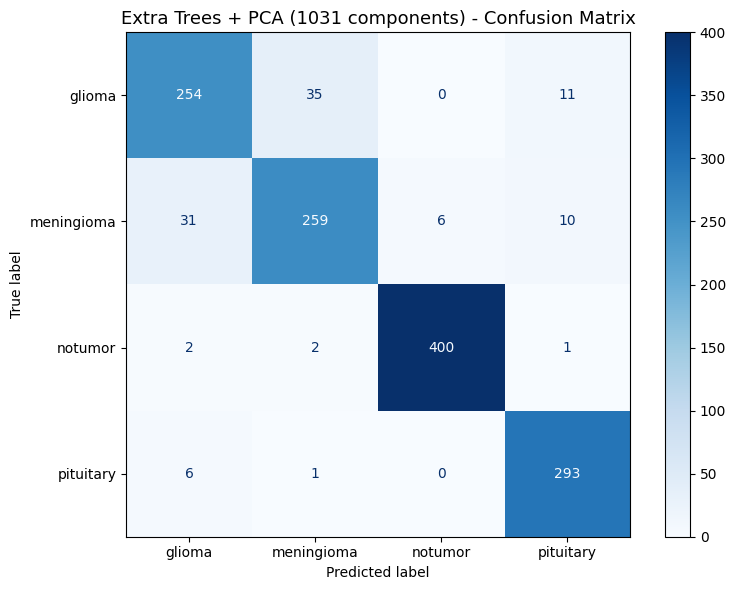

Confusion matrix saved to /kaggle/working/ExtraTrees_output/confusion_matrix.png


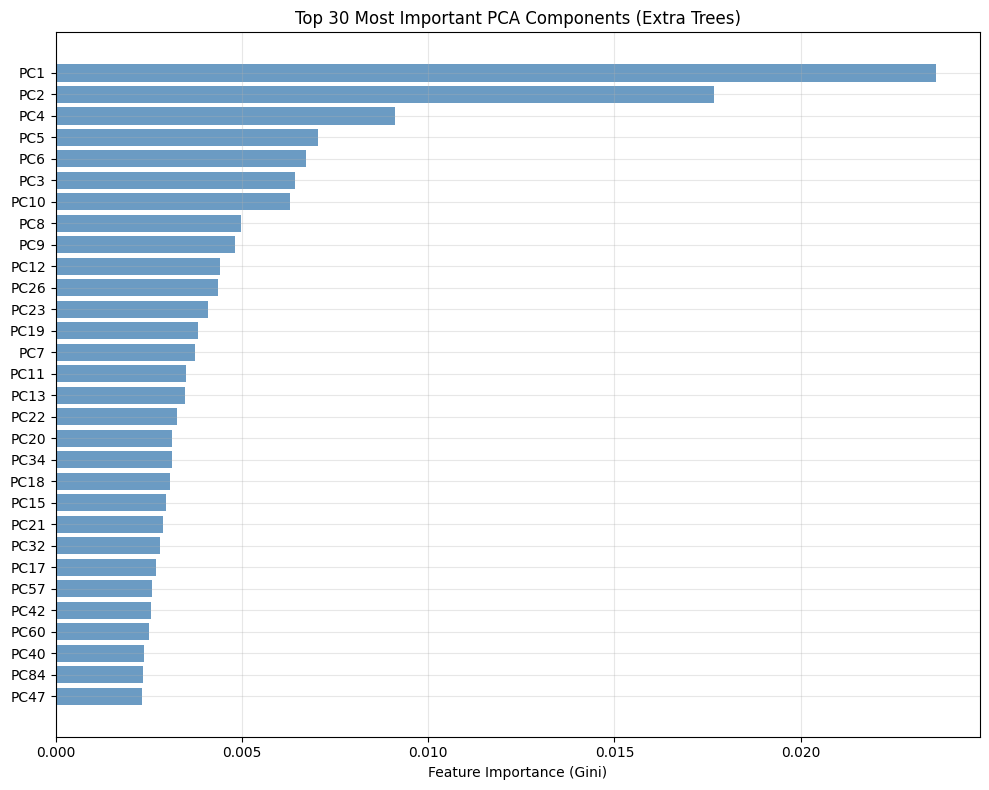

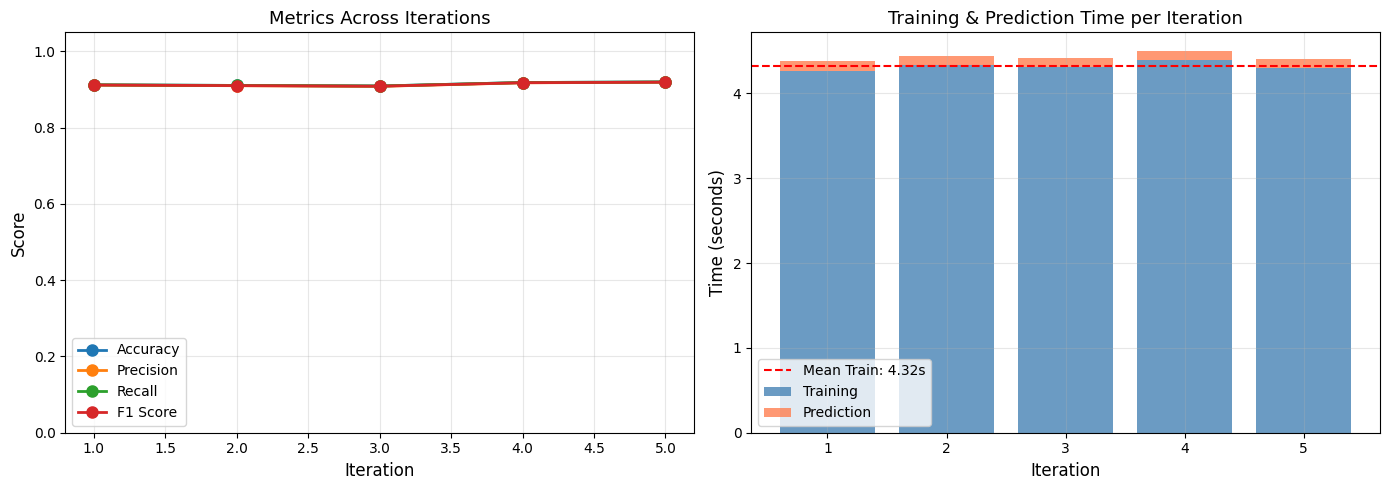

Metrics saved to /kaggle/working/ExtraTrees_output/metrics.json

Full results:
{
    "model": "Extra Trees",
    "gpu_accelerated": false,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 Extra Trees",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 269.08,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9141 \u00b1 0.0042",
        "Precision": "0.9134 \u00b1 0.0042",
   

In [9]:
# %% [markdown]
# # Brain Tumor Classification using Extra Trees
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** Extra Trees (Extremely Randomized Trees) Classifier  
# **Environment:** Kaggle P100 (Extra Trees is CPU-based; PCA reduces training time)
# 
# ### Pipeline
# Grayscale → Negative → Normalize → StandardScaler → PCA (95% variance) → Extra Trees

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

ET_PARAMS = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
}
# ============================================================

output_dir = '/kaggle/working/ExtraTrees_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train Extra Trees (5 Iterations)
# 
# Extra Trees is typically **faster than Random Forest** because it uses  
# random splits instead of searching for the best split at each node.  
# Expected ~1-3 min per iteration with PCA.

# %% [code]
model_name = "Extra Trees"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"ET Config: {ET_PARAMS}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    params = ET_PARAMS.copy()
    params['random_state'] = 42 + i

    model = ExtraTreesClassifier(**params)

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
total_predict_time = sum(predict_times)
print(f"\n{'=' * 60}")
print(f"Training Complete!")
print(f"Total train time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Feature Importance (Top 30 PCA Components)

# %% [code]
importances = model.feature_importances_
top_n = min(30, len(importances))
top_idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[top_idx], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{idx+1}' for idx in top_idx])
ax.set_xlabel('Feature Importance (Gini)')
ax.set_title(f'Top {top_n} Most Important PCA Components (Extra Trees)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 12. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": False,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → Extra Trees",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "et_params": {k: str(v) if v is None else v for k, v in ET_PARAMS.items()}
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 13. Download Outputs
# All outputs saved in `/kaggle/working/ExtraTrees_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `feature_importance.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → ExtraTrees(300 trees)")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")

Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading Testing Data...
Loading glioma: 300 images...
Loading meningioma: 306 images...
Loading notumor: 405 images...
Loading pituitary: 300 images...

Total training samples: 5712
Total testing samples: 1311

X_train (raw) shape: (5712, 62500)
X_test (raw) shape: (1311, 62500)
Applying StandardScaler + PCA Pipeline...

PCA Results:
  Original features:    62,500
  PCA components:       1031
  Variance retained:    95.01%
  Reduction:            98.4%
  PCA fitting time:     266.71s

X_train (PCA) shape: (5712, 1031)
X_test (P

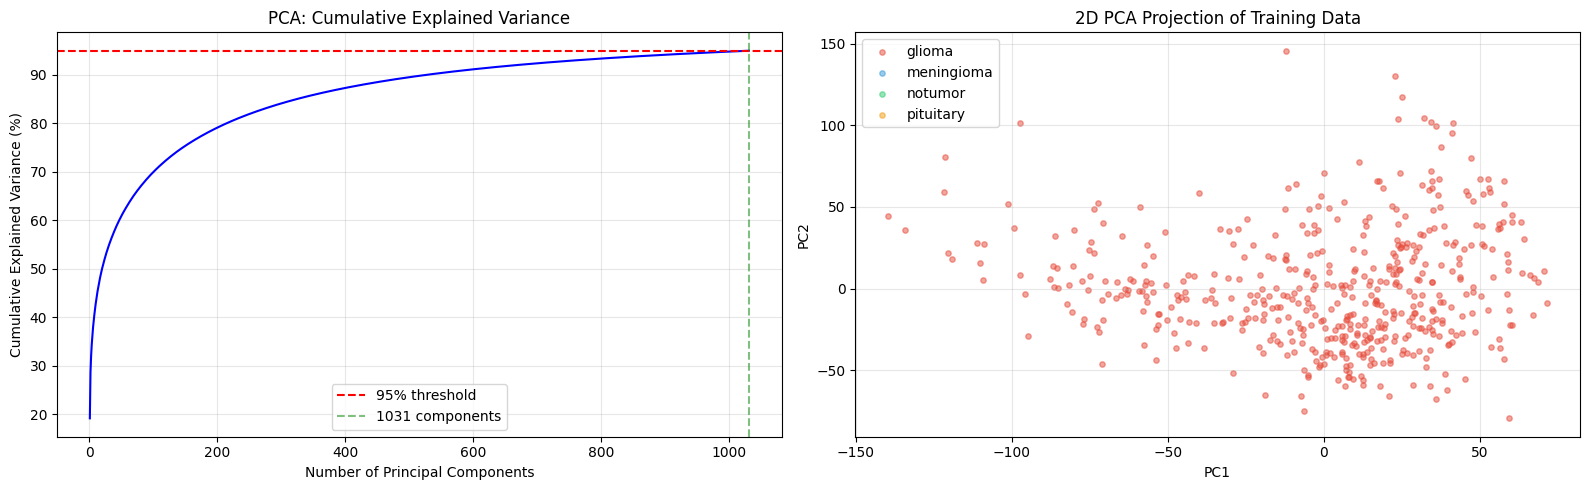

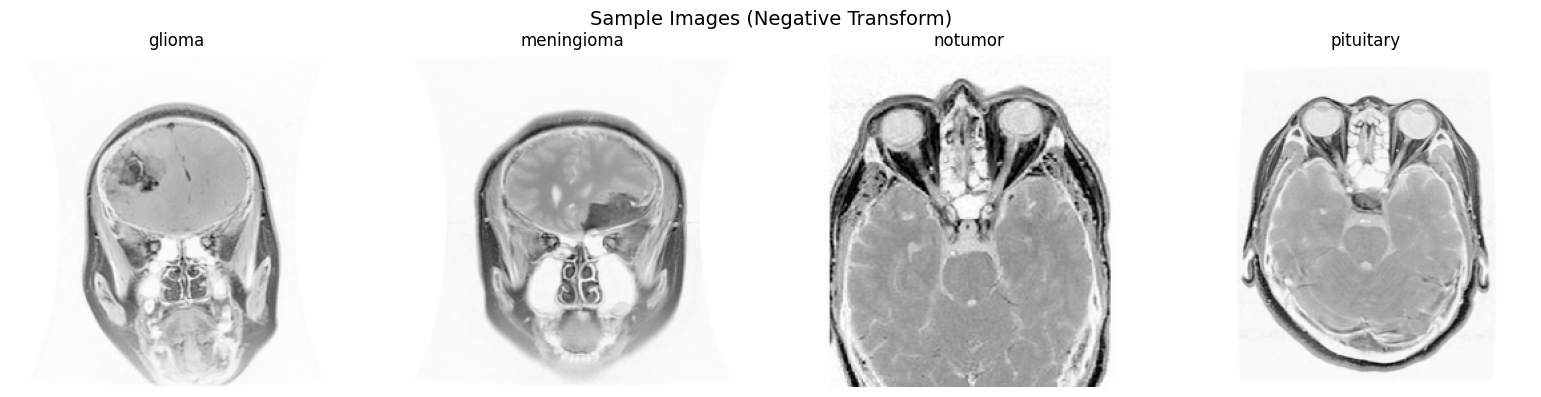

Training AdaBoost with PCA (1031 components) for 5 iterations...
AdaBoost Config: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME', 'random_state': 42}
Base Estimator: DecisionTree(max_depth=3)

--- Iteration 1/5 ---
  Training time:   638.55s
  Prediction time: 0.29s
  Accuracy:        0.8574
  F1 Score:        0.8558

--- Iteration 2/5 ---
  Training time:   607.70s
  Prediction time: 0.27s
  Accuracy:        0.8574
  F1 Score:        0.8558

--- Iteration 3/5 ---
  Training time:   600.06s
  Prediction time: 0.28s
  Accuracy:        0.8574
  F1 Score:        0.8558

--- Iteration 4/5 ---
  Training time:   598.67s
  Prediction time: 0.27s
  Accuracy:        0.8574
  F1 Score:        0.8558

--- Iteration 5/5 ---
  Training time:   597.08s
  Prediction time: 0.30s
  Accuracy:        0.8574
  F1 Score:        0.8558

Training Complete! Total time: 3042.06s (50.7 min)

Average Performance of AdaBoost + PCA (5 runs)
  Accuracy: 0.8574 ± 0.0000
  Precision: 0.8549 ± 0.000

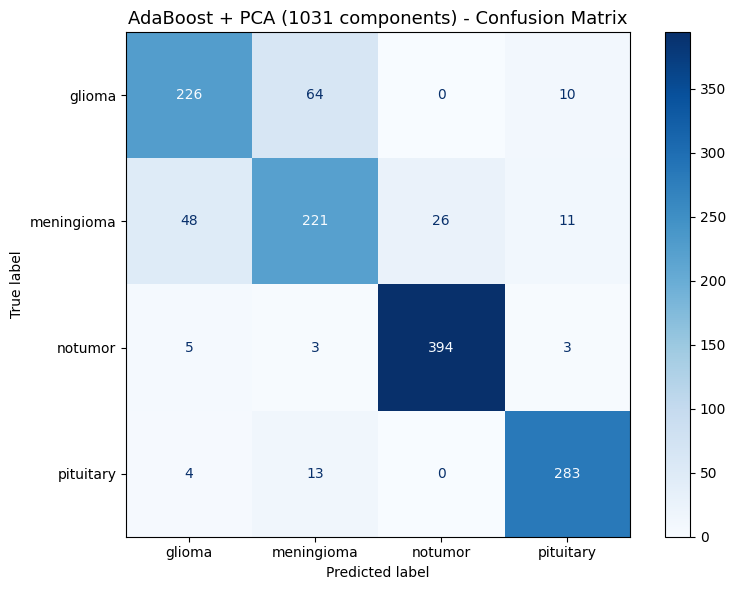

Confusion matrix saved to /kaggle/working/AdaBoost_output/confusion_matrix.png


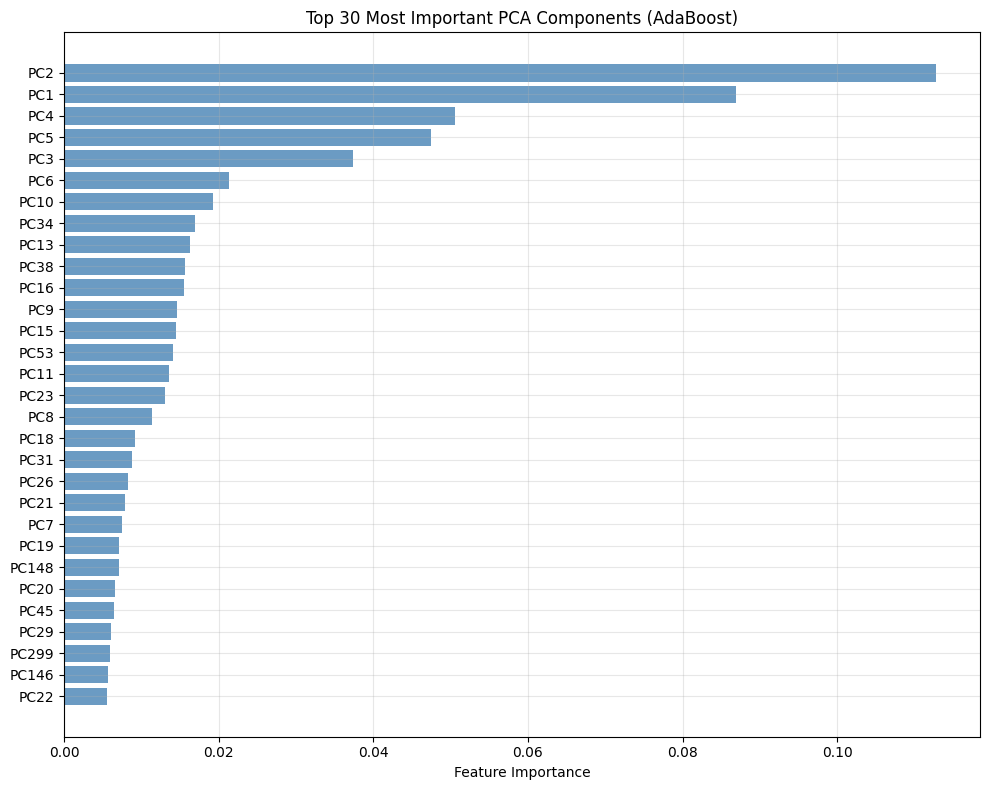

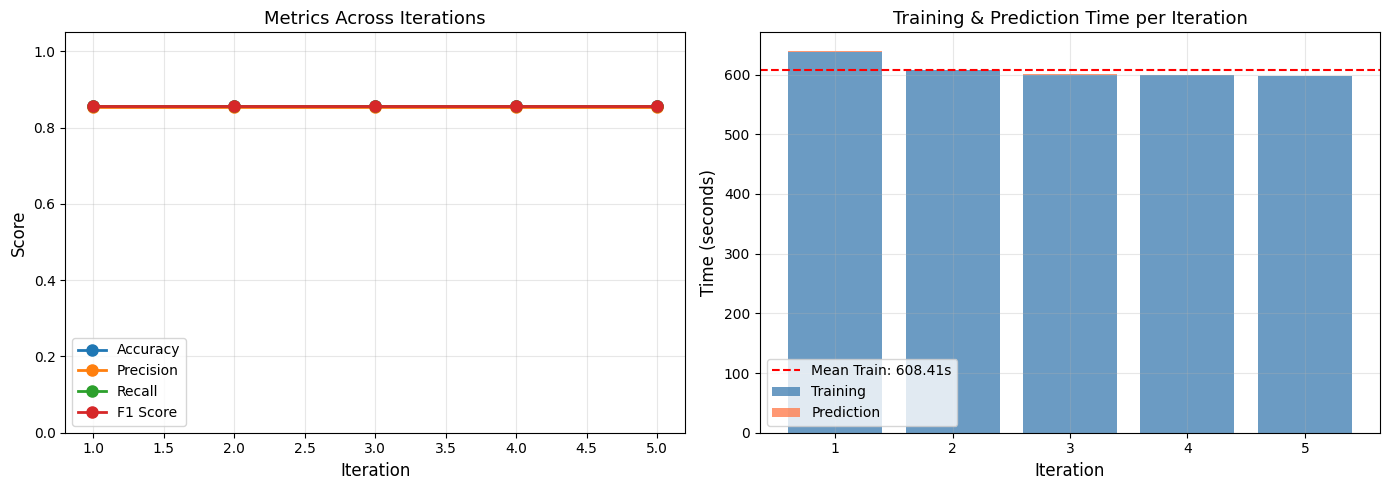

Metrics saved to /kaggle/working/AdaBoost_output/metrics.json

Full results:
{
    "model": "AdaBoost",
    "gpu_accelerated": false,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 AdaBoost",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 266.71,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.8574 \u00b1 0.0000",
        "Precision": "0.8549 \u00b1 0.0000",
        "Re

In [10]:
# %% [markdown]
# # Brain Tumor Classification using AdaBoost
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** AdaBoost (with Decision Tree base estimator)  
# **Environment:** Kaggle P100 (AdaBoost is CPU-based; PCA reduces training time)
# 
# ### Pipeline
# Grayscale → Negative → Normalize → StandardScaler → PCA (95% variance) → AdaBoost

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

ADABOOST_PARAMS = {
    'n_estimators': 200,
    'learning_rate': 0.5,
    'algorithm': 'SAMME',
    'random_state': 42,
}
BASE_ESTIMATOR_PARAMS = {
    'max_depth': 3,
}
# ============================================================

output_dir = '/kaggle/working/AdaBoost_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train AdaBoost (5 Iterations)
# 
# AdaBoost with Decision Tree (max_depth=3) base estimator.  
# With PCA features (~1000 components), expected ~2-5 min per iteration.

# %% [code]
model_name = "AdaBoost"

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"Training {model_name} with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"AdaBoost Config: {ADABOOST_PARAMS}")
print(f"Base Estimator: DecisionTree(max_depth={BASE_ESTIMATOR_PARAMS['max_depth']})")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    # Change random_state each iteration for variance measurement
    params = ADABOOST_PARAMS.copy()
    params['random_state'] = 42 + i

    base_estimator = DecisionTreeClassifier(
        max_depth=BASE_ESTIMATOR_PARAMS['max_depth'],
        random_state=params['random_state']
    )

    model = AdaBoostClassifier(
        estimator=base_estimator,
        **params
    )

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
print(f"\n{'=' * 60}")
print(f"Training Complete! Total time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Feature Importance (Top 30 PCA Components)

# %% [code]
importances = model.feature_importances_
top_n = min(30, len(importances))
top_idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[top_idx], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{idx+1}' for idx in top_idx])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Most Important PCA Components (AdaBoost)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 12. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": False,
    "pipeline": "Grayscale → Negative → Normalize → StandardScaler → PCA → AdaBoost",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "adaboost_params": ADABOOST_PARAMS,
    "base_estimator": f"DecisionTree(max_depth={BASE_ESTIMATOR_PARAMS['max_depth']})"
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 13. Download Outputs
# All outputs saved in `/kaggle/working/AdaBoost_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `feature_importance.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → AdaBoost(SAMME)")
print(f"  Base Est:     DecisionTree(max_depth={BASE_ESTIMATOR_PARAMS['max_depth']})")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")

LightGBM version: 4.6.0
Tue Feb 17 10:33:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|       
Training path exists: True
Testing path exists: True
  Training/glioma: 1321 images
  Training/meningioma: 1339 images
  Training/notumor: 1595 images
  Training/pituitary: 1457 images
  Testing/glioma: 300 images
  Testing/meningioma: 306 images
  Testing/notumor: 405 images
  Testing/pituitary: 300 images
Loading Training Data...
Loading glioma: 1321 images...
Loading meningioma: 1339 images...
Loading notumor: 1595 images...
Loading pituitary: 1457 images...

Loading 

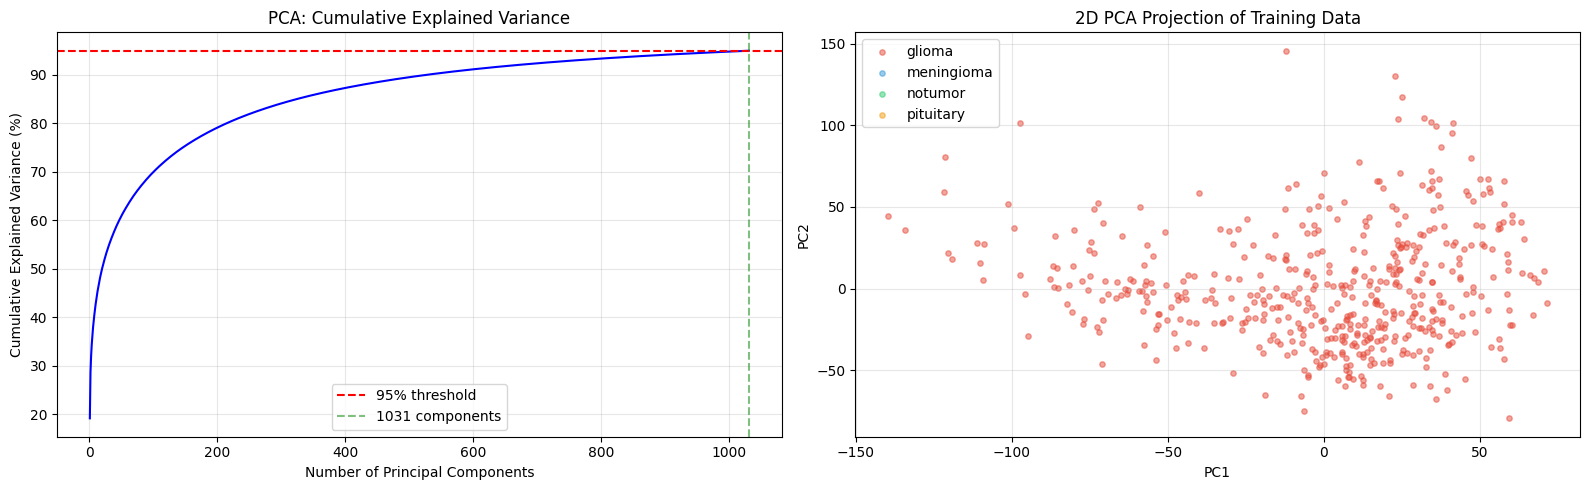

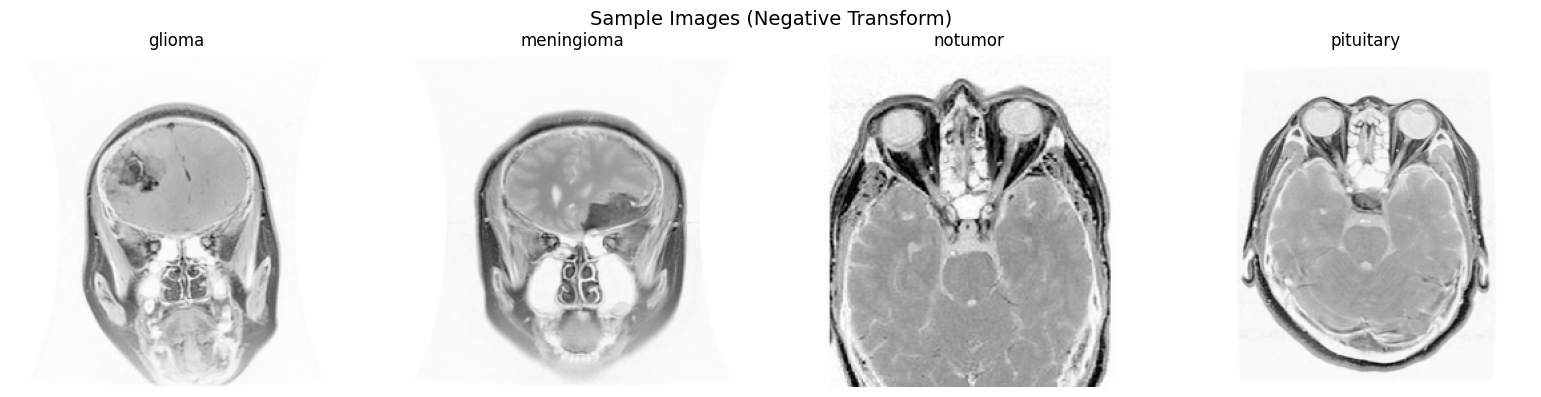

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


GPU acceleration enabled!

Training LightGBM (GPU) with PCA (1031 components) for 5 iterations...
LightGBM Config: n_estimators=300, max_depth=6, lr=0.1, num_leaves=63

--- Iteration 1/5 ---


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


  Training time:   49.34s
  Prediction time: 0.06s
  Accuracy:        0.9321
  F1 Score:        0.9314

--- Iteration 2/5 ---
  Training time:   45.86s
  Prediction time: 0.06s
  Accuracy:        0.9344
  F1 Score:        0.9338

--- Iteration 3/5 ---
  Training time:   45.84s
  Prediction time: 0.06s
  Accuracy:        0.9336
  F1 Score:        0.9330

--- Iteration 4/5 ---
  Training time:   45.52s
  Prediction time: 0.06s
  Accuracy:        0.9329
  F1 Score:        0.9322

--- Iteration 5/5 ---
  Training time:   45.54s
  Prediction time: 0.06s
  Accuracy:        0.9321
  F1 Score:        0.9315

Training Complete! Total time: 232.11s (3.9 min)

Average Performance of LightGBM + PCA (5 runs)
  Accuracy: 0.9330 ± 0.0009
  Precision: 0.9323 ± 0.0010
  Recall: 0.9330 ± 0.0009
  F1 Score: 0.9324 ± 0.0009
  Training Time:   46.42s ± 1.47s
  Prediction Time: 0.06s
  PCA Time:        272.41s (one-time)
  GPU Used:        True

Classification Report (Last Iteration)
              precision

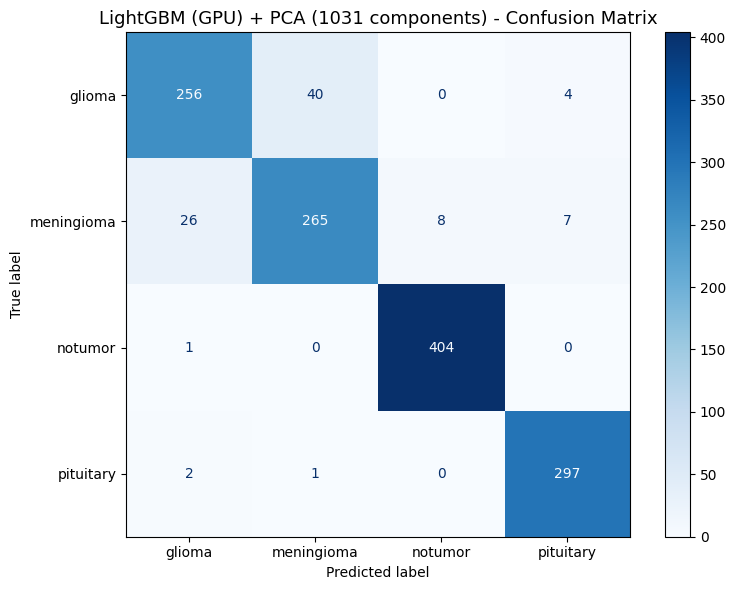

Confusion matrix saved to /kaggle/working/LightGBM_output/confusion_matrix.png


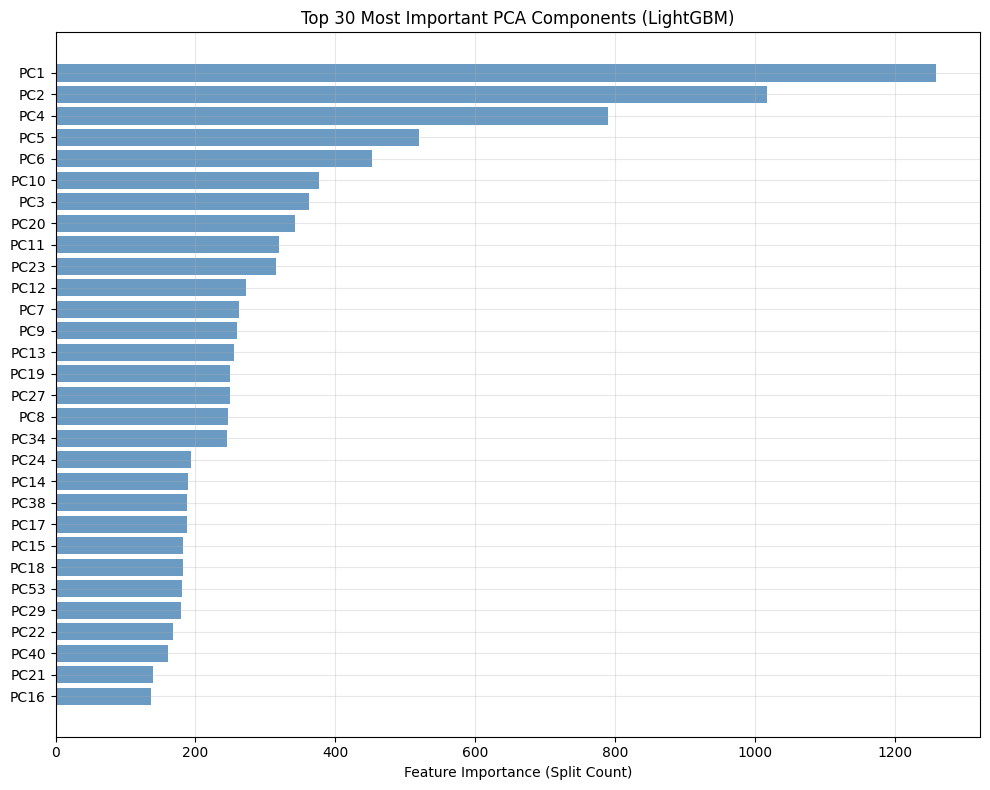

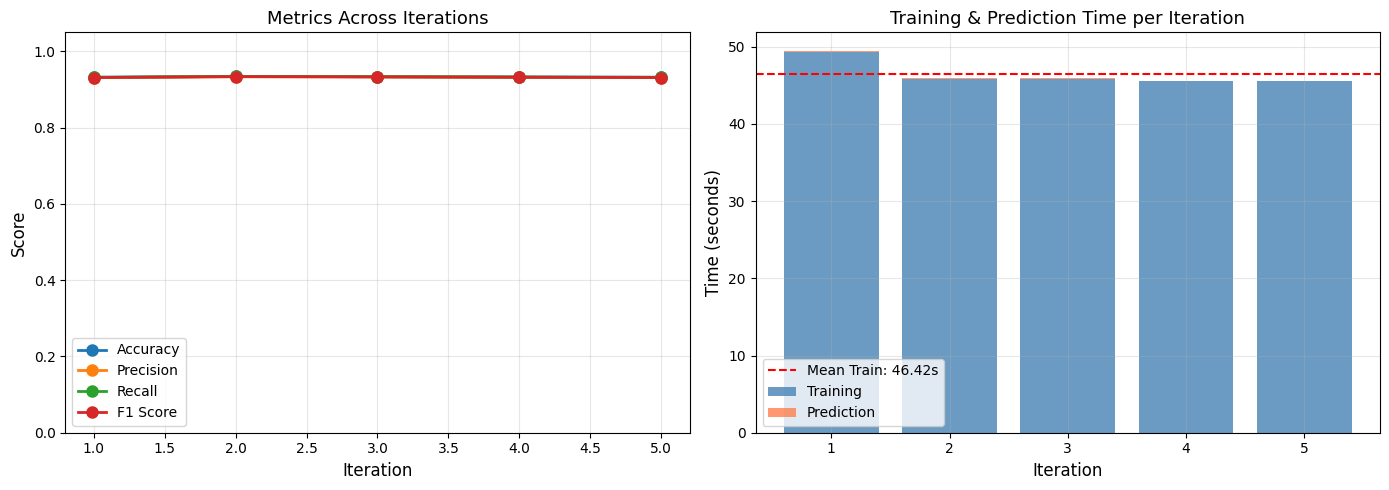

Metrics saved to /kaggle/working/LightGBM_output/metrics.json

Full results:
{
    "model": "LightGBM",
    "gpu_accelerated": true,
    "pipeline": "Grayscale \u2192 Negative \u2192 Normalize \u2192 StandardScaler \u2192 PCA \u2192 LightGBM (GPU)",
    "num_iterations": 5,
    "image_size": 250,
    "original_features": 62500,
    "pca_components": 1031,
    "pca_variance_retained": "95.01%",
    "pca_time_seconds": 272.41,
    "dimensionality_reduction": "62500 \u2192 1031 (98.4% reduction)",
    "train_samples": 5712,
    "test_samples": 1311,
    "class_distribution": {
        "train": {
            "glioma": 1321,
            "meningioma": 1339,
            "notumor": 1595,
            "pituitary": 1457
        },
        "test": {
            "glioma": 300,
            "meningioma": 306,
            "notumor": 405,
            "pituitary": 300
        }
    },
    "average_metrics": {
        "Accuracy": "0.9330 \u00b1 0.0009",
        "Precision": "0.9323 \u00b1 0.0010",
      

In [1]:
# %% [markdown]
# # Brain Tumor Classification using LightGBM (GPU-Accelerated)
# **Dataset:** Brain Tumor MRI Dataset (glioma, meningioma, notumor, pituitary)  
# **Model:** LightGBM with GPU acceleration  
# **Environment:** Kaggle P100 — LightGBM supports GPU natively!
# 
# ### Pipeline
# Grayscale → Negative → Normalize → StandardScaler → PCA (95% variance) → LightGBM (GPU)

# %% [code]
import os
import numpy as np
import time
import json
import matplotlib.pyplot as plt
from PIL import Image
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import warnings
warnings.filterwarnings('ignore')

print(f"LightGBM version: {lgb.__version__}")

# Check GPU
import subprocess
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print(result.stdout[:500])
except:
    print("No GPU detected")

# %% [markdown]
# ## 1. Setup Paths & Configuration

# %% [code]
# ============================================================
# UPDATE THIS PATH to match your Kaggle dataset
# ============================================================
DATASET_BASE = '/kaggle/input/datasets/usable1234/training/Dataset'

path_train = os.path.join(DATASET_BASE, 'Training')
path_test = os.path.join(DATASET_BASE, 'Testing')
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 250

# ============================================================
# HYPERPARAMETERS
# ============================================================
PCA_VARIANCE = 0.95
NUM_ITERATIONS = 5

LGBM_PARAMS = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
}
# ============================================================

output_dir = '/kaggle/working/LightGBM_output'
os.makedirs(output_dir, exist_ok=True)

# Verify paths
print("Training path exists:", os.path.exists(path_train))
print("Testing path exists:", os.path.exists(path_test))

if os.path.exists(path_train):
    for label in labels:
        p = os.path.join(path_train, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Training/{label}: {count} images")

if os.path.exists(path_test):
    for label in labels:
        p = os.path.join(path_test, label)
        count = len(os.listdir(p)) if os.path.exists(p) else 0
        print(f"  Testing/{label}: {count} images")

# %% [markdown]
# ## 2. Data Loading & Preprocessing Functions

# %% [code]
def import_data(data_path, labels, img_size):
    """Load images from folder structure."""
    images = []
    image_labels = []

    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping.")
            continue

        files = sorted(os.listdir(folder_path))
        print(f"Loading {label}: {len(files)} images...")

        for filename in files:
            filepath = os.path.join(folder_path, filename)
            try:
                img = Image.open(filepath).convert('L')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)
                images.append(img_array)
                image_labels.append(label_idx)
            except Exception as e:
                print(f"Error loading {filepath}: {e}")

    return images, image_labels


def data_to_negative(images):
    """Convert images to negative (invert pixel values)."""
    return [255 - img for img in images]

# %% [markdown]
# ## 3. Load & Preprocess Data

# %% [code]
print("=" * 60)
print("Loading Training Data...")
print("=" * 60)
x_train, y_train = import_data(path_train, labels, IMG_SIZE)

print(f"\n{'=' * 60}")
print("Loading Testing Data...")
print("=" * 60)
x_test, y_test = import_data(path_test, labels, IMG_SIZE)

print(f"\nTotal training samples: {len(x_train)}")
print(f"Total testing samples: {len(x_test)}")

# Apply negative transformation
x_train = data_to_negative(x_train)
x_test = data_to_negative(x_test)

# Normalize to [0, 1]
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

# Flatten images
X_train_flat = np.vstack([image.flatten() for image in x_train])
X_test_flat = np.vstack([image.flatten() for image in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

del x_train, x_test

print(f"\nX_train (raw) shape: {X_train_flat.shape}")
print(f"X_test (raw) shape: {X_test_flat.shape}")

# %% [markdown]
# ## 4. StandardScaler + PCA

# %% [code]
print("=" * 60)
print("Applying StandardScaler + PCA Pipeline...")
print("=" * 60)

pca_start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

del X_train_flat, X_test_flat

pca = PCA(n_components=PCA_VARIANCE, svd_solver='full')
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

del X_train_scaled, X_test_scaled

pca_time = time.time() - pca_start

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_) * 100

print(f"\nPCA Results:")
print(f"  Original features:    {IMG_SIZE * IMG_SIZE:,}")
print(f"  PCA components:       {n_components}")
print(f"  Variance retained:    {explained_var:.2f}%")
print(f"  Reduction:            {(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}%")
print(f"  PCA fitting time:     {pca_time:.2f}s")
print(f"\nX_train (PCA) shape: {X_train.shape}")
print(f"X_test (PCA) shape:  {X_test.shape}")

# %% [markdown]
# ## 5. PCA Visualization

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Cumulative explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'b-', linewidth=1.5)
axes[0].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', alpha=0.5, label=f'{n_components} components')
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[0].set_title('PCA: Cumulative Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D PCA projection
from sklearn.decomposition import PCA as PCA2
pca_viz = PCA2(n_components=2)
X_viz = pca_viz.fit_transform(X_train[:500])
y_viz = y_train[:500]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for i, label in enumerate(labels):
    mask = y_viz == i
    axes[1].scatter(X_viz[mask, 0], X_viz[mask, 1], c=colors[i],
                    label=label, alpha=0.5, s=15)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('2D PCA Projection of Training Data')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Sample Images

# %% [code]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(labels):
    folder = os.path.join(path_train, label)
    sample_file = sorted(os.listdir(folder))[0]
    img = Image.open(os.path.join(folder, sample_file)).convert('L').resize((IMG_SIZE, IMG_SIZE))
    img_neg = 255 - np.array(img)
    axes[i].imshow(img_neg, cmap='gray')
    axes[i].set_title(f'{label}')
    axes[i].axis('off')
plt.suptitle('Sample Images (Negative Transform)', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Train LightGBM with GPU (5 Iterations)
# 
# LightGBM natively supports GPU via `device='gpu'`.  
# Expected: ~5-15 seconds per iteration with PCA features.

# %% [code]
model_name = "LightGBM"

# Test GPU availability - fall back to CPU if needed
try:
    test_model = lgb.LGBMClassifier(device='gpu', gpu_platform_id=0, gpu_device_id=0,
                                     n_estimators=5, verbose=-1)
    test_model.fit(X_train[:100], y_train[:100])
    USE_GPU = True
    print("GPU acceleration enabled!")
except Exception as e:
    USE_GPU = False
    print(f"GPU not available for LightGBM ({e}), falling back to CPU")
    LGBM_PARAMS['device'] = 'cpu'
    del LGBM_PARAMS['gpu_platform_id']
    del LGBM_PARAMS['gpu_device_id']

metrics_funcs = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score
}

scores = {metric_name: [] for metric_name in metrics_funcs}
train_times = []
predict_times = []
last_y_pred = None

print(f"\nTraining {model_name} ({'GPU' if USE_GPU else 'CPU'}) with PCA ({n_components} components) for {NUM_ITERATIONS} iterations...")
print(f"LightGBM Config: n_estimators={LGBM_PARAMS['n_estimators']}, max_depth={LGBM_PARAMS['max_depth']}, "
      f"lr={LGBM_PARAMS['learning_rate']}, num_leaves={LGBM_PARAMS['num_leaves']}")
print("=" * 60)

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")

    params = LGBM_PARAMS.copy()
    params['random_state'] = 42 + i

    model = lgb.LGBMClassifier(**params)

    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict
    pred_start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - pred_start

    last_y_pred = y_pred
    train_times.append(training_time)
    predict_times.append(predict_time)

    for metric_name, metric_func in metrics_funcs.items():
        if metric_name == "Accuracy":
            score = metric_func(y_test, y_pred)
        else:
            score = metric_func(y_test, y_pred, average='weighted')
        scores[metric_name].append(score)

    print(f"  Training time:   {training_time:.2f}s")
    print(f"  Prediction time: {predict_time:.2f}s")
    print(f"  Accuracy:        {scores['Accuracy'][-1]:.4f}")
    print(f"  F1 Score:        {scores['F1 Score'][-1]:.4f}")

total_train_time = sum(train_times)
print(f"\n{'=' * 60}")
print(f"Training Complete! Total time: {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print("=" * 60)

# %% [markdown]
# ## 8. Results & Statistics

# %% [code]
avg_scores = {k: np.mean(v) for k, v in scores.items()}
std_scores = {k: np.std(v) for k, v in scores.items()}
avg_time = np.mean(train_times)
std_time = np.std(train_times)
avg_pred_time = np.mean(predict_times)

print(f"\n{'=' * 60}")
print(f"Average Performance of {model_name} + PCA ({NUM_ITERATIONS} runs)")
print(f"{'=' * 60}")
for metric_name, avg_score in avg_scores.items():
    std_score = std_scores[metric_name]
    print(f"  {metric_name}: {avg_score:.4f} ± {std_score:.4f}")
print(f"  Training Time:   {avg_time:.2f}s ± {std_time:.2f}s")
print(f"  Prediction Time: {avg_pred_time:.2f}s")
print(f"  PCA Time:        {pca_time:.2f}s (one-time)")
print(f"  GPU Used:        {USE_GPU}")

print(f"\n{'=' * 60}")
print("Classification Report (Last Iteration)")
print(f"{'=' * 60}")
print(classification_report(y_test, last_y_pred, target_names=labels))

# %% [markdown]
# ## 9. Confusion Matrix

# %% [code]
cm = confusion_matrix(y_test, last_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"{model_name} ({'GPU' if USE_GPU else 'CPU'}) + PCA ({n_components} components) - Confusion Matrix", fontsize=13)
plt.tight_layout()
cm_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix saved to {cm_path}")

# %% [markdown]
# ## 10. Feature Importance (Top 30 PCA Components)

# %% [code]
importances = model.feature_importances_
top_n = min(30, len(importances))
top_idx = np.argsort(importances)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), importances[top_idx], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f'PC{idx+1}' for idx in top_idx])
ax.set_xlabel('Feature Importance (Split Count)')
ax.set_title(f'Top {top_n} Most Important PCA Components (LightGBM)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 11. Performance Across Iterations

# %% [code]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

iterations = range(1, NUM_ITERATIONS + 1)
for metric_name, score_list in scores.items():
    axes[0].plot(iterations, score_list, 'o-', label=metric_name, linewidth=2, markersize=8)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics Across Iterations', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

axes[1].bar(iterations, train_times, color='steelblue', alpha=0.8, label='Training')
axes[1].bar(iterations, predict_times, bottom=train_times, color='coral', alpha=0.8, label='Prediction')
axes[1].axhline(y=avg_time, color='red', linestyle='--', label=f'Mean Train: {avg_time:.2f}s')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training & Prediction Time per Iteration', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'performance_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 12. Save Metrics to JSON

# %% [code]
results = {
    "model": model_name,
    "gpu_accelerated": USE_GPU,
    "pipeline": f"Grayscale → Negative → Normalize → StandardScaler → PCA → LightGBM ({'GPU' if USE_GPU else 'CPU'})",
    "num_iterations": NUM_ITERATIONS,
    "image_size": IMG_SIZE,
    "original_features": IMG_SIZE * IMG_SIZE,
    "pca_components": int(n_components),
    "pca_variance_retained": f"{explained_var:.2f}%",
    "pca_time_seconds": round(pca_time, 2),
    "dimensionality_reduction": f"{IMG_SIZE*IMG_SIZE} → {n_components} ({(1 - n_components/(IMG_SIZE*IMG_SIZE))*100:.1f}% reduction)",
    "train_samples": int(len(y_train)),
    "test_samples": int(len(y_test)),
    "class_distribution": {
        "train": {label: int(np.sum(y_train == i)) for i, label in enumerate(labels)},
        "test": {label: int(np.sum(y_test == i)) for i, label in enumerate(labels)}
    },
    "average_metrics": {
        k: f"{v:.4f} ± {std_scores[k]:.4f}" for k, v in avg_scores.items()
    },
    "raw_scores": {k: [round(s, 4) for s in v] for k, v in scores.items()},
    "training_times": [round(t, 2) for t in train_times],
    "prediction_times": [round(t, 2) for t in predict_times],
    "training_time_avg": f"{avg_time:.2f} ± {std_time:.2f}",
    "total_training_time": f"{total_train_time:.2f}s ({total_train_time/60:.1f} min)",
    "lgbm_params": {k: str(v) for k, v in LGBM_PARAMS.items()}
}

metrics_path = os.path.join(output_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"Metrics saved to {metrics_path}")
print("\nFull results:")
print(json.dumps(results, indent=4))

# %% [markdown]
# ## 13. Download Outputs
# All outputs saved in `/kaggle/working/LightGBM_output/`:
# - `confusion_matrix.png`
# - `sample_images.png`
# - `pca_analysis.png`
# - `feature_importance.png`
# - `performance_plots.png`
# - `metrics.json`

# %% [code]
print("\nOutput files:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

print(f"\n{'=' * 60}")
print("SUMMARY")
print(f"{'=' * 60}")
print(f"  Pipeline:     Image → Negative → Scale → PCA({n_components}) → LightGBM({'GPU' if USE_GPU else 'CPU'})")
print(f"  GPU Used:     {USE_GPU}")
print(f"  Accuracy:     {avg_scores['Accuracy']:.4f} ± {std_scores['Accuracy']:.4f}")
print(f"  F1 Score:     {avg_scores['F1 Score']:.4f} ± {std_scores['F1 Score']:.4f}")
print(f"  Train Time:   {avg_time:.2f}s per iteration")
print(f"  Total Time:   {total_train_time:.2f}s ({total_train_time/60:.1f} min)")
print(f"{'=' * 60}")